# ChemCharts JSON Plot 

## PREPARATION 
Bevor using this notebook dependencies need to be loaded and paths updated.

In [2]:

# load dependencies
import os
import json
import tempfile
from IPython.display import Image

# change these paths to match your system's configuration
chemcharts_dir = os.path.expanduser("~/Documents/Projects/ChemCharts") # set project folder on your device
chemcharts_env = os.path.expanduser("~/miniconda3/envs/chemcharts")    # set environment path on your device
output_dir = os.path.expanduser("~/Desktop/chemcharts_json_test")      # set output path on your device

# do NOT change me
try: ipynb_path                                                   
except NameError: ipynb_path = os.getcwd()                             # sets root path

try:
    os.mkdir(output_dir)                                               # checks whether there is an output folder 
except FileExistsError:                                                # and generates one if there isn't one already available
    pass


## INITIALIZATION 
The following cells will construct a `JSON` configuration file step-by-step by adding options to a dictionary, which is then written out to a file. Afterwards, this configuration file is used to run `ChemCharts`.

In [3]:

conf={"chemcharts": {}}


### Header 
Add a header if needed.

In [4]:

conf={
  "chemcharts": {
    "header": {}                                                        # leave empty if not needed
  }
}


## EXECUTION
### Data loading
Now you can start adding tasks to the config file. Data loading is the obligatory first step. Note, that you can also load previous, pickled and pre-processed data files. The column names used below conform to the `REINVENT` scaffold memory format.

In [5]:

conf["chemcharts"]["execution"] = [
      {"task":  "data_loading",
       "input":  os.path.join(chemcharts_dir, "data/scaffold_memory.csv"),
       "input_type":  "csv",
       "columns":  {
                     "smiles_column": "SMILES",
                     "values_columns": ["total_score", "raw_dockstream", "QED Score"],        
                     "epochs_column": "Step"
                    }
      }]
    

Note: For generating plots with 'ChemCharts' you can either use a single value or a list of values. The hexagonal, scatter boxplot in "plain" mode and the 2D contour plot are the only plots which works without any value input at all, every other plot requires at least one value.

### Generate fingerprints
Once the data is loaded, we need to translate the chemical strings (SMILES) into fingerprints. There are a couple of different options, here we will use MACCS.

In [6]:

conf["chemcharts"]["execution"].append(
      {"task":  "generate_fingerprints",
       "type":  "maccs",                                                # you can choose between standard, morgan and maccs
       "parameters":  {"useFeatures": True}                             # with the other two fingerprints there are no parameters
      })


### Dimensional reduction
Reduce the number of features in your dataset with an `UMAP` algorithm to two dimensions.

In [7]:

conf["chemcharts"]["execution"].append(
      {"task":  "dimensional_reduction",
       "type": "UMAP",
       "parameters":  {}
      })


### Optional: Filtering
You can define a filter range to reduce the input data to a given range. These operate on the embedded dimensions UMAP_1 and UMAP_2.

In [8]:

conf["chemcharts"]["execution"].append(
      {"task":  "filtering_data",
       "type": "filtering",
       "parameters":  {"range_dim1": [-100, 100],                       # set range for UMAP_1
                       "range_dim2": [-100, 100]}                       # set range for UMAP_2
      })


### Optional: Clustering
You can further prepare the data by clustering it with `KMeans`.

In [9]:

conf["chemcharts"]["execution"].append(
      {"task":  "clustering_data",
       "type": "KMmeans",
       "parameters":  {"k": 10}                                         # set the number of desired KMeans clusters
      })


### Optional: Binning
You might also want to bin the scores and return their median in order to "flatten" the score surface.

In [10]:

conf["chemcharts"]["execution"].append(
      {"task":  "binning_values",
       "type": "binning",
       "parameters":  {"num_bins": 4}                                    # set the number of desired bins
      })


### Write-Out
When using large data sets, it is advisable to write out the updated data and use the `pkl` file generated as input for further tasks (potentially very time saving).

In [11]:

# write-out of data into a pkl file ("simple_plot_test.pkl")
conf["chemcharts"]["execution"].append({
        "task": "write_out",
        "f_type": "pkl",
        "path": os.path.join(output_dir, "simple_plot_test.pkl")           # choose loaction for ".pkl" file
      })


In [12]:

# write-out of configuration file
conf_preprocess_JSON_path = os.path.join(output_dir, "chemcharts_preprocess_data_simple.json")
with open(conf_preprocess_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    

In [13]:

# write-out of data in csv file 
# file will include UMAP1, UMAP_2 and SMILES and if available Epochs, Groups and Values (values_columns) as well
conf["chemcharts"]["execution"].append({
        "task": "write_out",
        "f_type": "csv",
        "path": os.path.join(output_dir, "data.csv")           # choose location for ".csv" file
      })

# Note: if multiple datasets are provided there will be counts added to the csv output files e.g. data_1.csv, data_2.csv, ...

In [14]:

# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {conf_preprocess_JSON_path}


Task data_loading completed.
Task generate_fingerprints completed.
Task dimensional_reduction completed.
Task filtering_data completed.
Task clustering_data completed.
Task binning_values completed.
Task write_out completed.


### PKL Variants
You can also generate multiple `pkl` files with different datasets in order to quickly change the input when generating the plots (allows for time efficient plotting).

In [15]:

# pkl with multiple datasets ("multiple_plot_test.pkl")
conf= {
    "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(chemcharts_dir, "data/scaffold_memory.csv"),
                  os.path.join(chemcharts_dir, "data/scaffold_memory_run2.csv"), 
                  os.path.join(chemcharts_dir, "data/scaffold_memory_run3.csv")],
       "input_type":  "csv",
       "columns":  {
                     "smiles_column": "SMILES",
                     "values_columns": ["total_score", "raw_dockstream", "QED Score"],
                     "epochs_column": "Step"
                    }
      },
      {"task":  "generate_fingerprints",
       "type":  "standard",
       "parameters":  {}
      },
      {"task":  "dimensional_reduction",
       "type": "UMAP",
       "parameters":  {}
      },
      {"task":  "filtering_data",
       "type": "filtering",
       "parameters":  {"range_dim1": [-50, 50],
                       "range_dim2": [-50, 50]}
      },
      {"task":  "clustering_data",
       "type": "KMmeans",
       "parameters":  {"k": 50}
      },
      {"task":  "binning_values",
       "type": "binning",
       "parameters":  {"num_bins": 10}
      },
      {
        "task": "write_out",
        "f_type": "pkl",
        "path": os.path.join(output_dir, "multiple_plot_test.pkl")
      },
      {
        "task": "write_out",
        "f_type": "csv",
        "path": os.path.join(output_dir, "multiple_plot_data.csv")
      }
    ]
  }
}

# write-out of configuration file
conf_preprocess_JSON_path = os.path.join(output_dir, "chemcharts_preprocess_data_multiple.json")
with open(conf_preprocess_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {conf_preprocess_JSON_path}


Task data_loading completed.
Task generate_fingerprints completed.
Task dimensional_reduction completed.
Task filtering_data completed.
Task clustering_data completed.
Task binning_values completed.
Task write_out completed.
Task write_out completed.


In [16]:

# pkl with groups datasets ("groups_plot_test.pkl")
conf= {
    "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  os.path.join(chemcharts_dir, "data/scaffold_memory_groups.csv"),
       "input_type":  "csv",
       "columns":  {
                     "smiles_column": "SMILES",
                     "values_columns": ["total_score", "raw_dockstream", "QED Score"],
                     "epochs_column": "Step",
                     "groups_column": "groups"
                    }
      },
      {"task":  "generate_fingerprints",
       "type":  "standard",
       "parameters":  {}
      },
      {"task":  "dimensional_reduction",
       "type": "UMAP",
       "parameters":  {}
      },
      {"task":  "filtering_data",
       "type": "filtering",
       "parameters":  {"range_dim1": [-50, 50],
                       "range_dim2": [-50, 50]}
      },
      {"task":  "clustering_data",
       "type": "KMmeans",
       "parameters":  {"k": 50}
      },
      {"task":  "binning_values",
       "type": "binning",
       "parameters":  {"num_bins": 10}
      },
      {
        "task": "write_out",
        "f_type": "pkl",
        "path": os.path.join(output_dir, "groups_plot_test.pkl")
      },
      {
        "task": "write_out",
        "f_type": "csv",
        "path": os.path.join(output_dir, "groups_plot_data.csv")
      }
    ]
  }
}

# write-out of configuration file
conf_preprocess_JSON_path = os.path.join(output_dir, "chemcharts_preprocess_data_groups.json")
with open(conf_preprocess_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {conf_preprocess_JSON_path}


Task data_loading completed.
Task generate_fingerprints completed.
Task dimensional_reduction completed.
Task filtering_data completed.
Task clustering_data completed.
Task binning_values completed.
Task write_out completed.
Task write_out completed.


## PLOT GENERATION
### Example: Hexagonal plot generation
Once the updated data is saved in a `pkl` file you can start generating various plots.

In [17]:

# now you can load the data from the pkl file and generate the plot
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",                                             # choose plot type (here: Hexagonal)
       "parameters":  {"title": "Hexagonal ChemCharts Plot",                 # set plot title 
                                                                             # (default: Hexagonal Chemcharts Plot)
                       "gridsize": 20,                                       # set gridsize {default: 20}
                       "fontsize": 14,                                       # set fontsize of dataset title (default: 14) 
                       "top": 0.9,                                           # set top margin (default: 0.9)    
                       "color": "#4CB391",                                   # set marker color with a hex color code 
                                                                             # (default: #4CB391) 
                                                                             # when using a list of hex color codes 
                                                                             # you might want to have white as first value
                                                                             # to allow for a white background color
                                                                             # e.g. ["#FFFFFF", "#cc0000", "#003ba3", "#006600"]
                       "cross_object_normalize": False,                      # set on "False" if normalization over all    
                                                                             # datapoints is NOT desired (default: true)
                                                                             # Note: If a value input is given, the cross-object 
                                                                             # normalization is only possible with valuelim set!
                                                                             # e.g. "valuelim": [0, 1]
                       "value_input": "total_score"                          # set values to calculate their median (per hexagon)
                                                                             # if no values are set the mean will be calculated
                      },
        "settings": {"path": os.path.join(output_dir, "hexagonal_plot.png"), # set output path including file name
                     "format": "png",                                        # set file format (default: png)  
                     "dpi": 150,                                             # set dpi (default: 150)
                     "figsize": [8, 8]}                                      # set figure size (default: [8, 8]) 
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_hex_simple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True) 
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}


Task data_loading completed.
None
Task generate_plot completed.


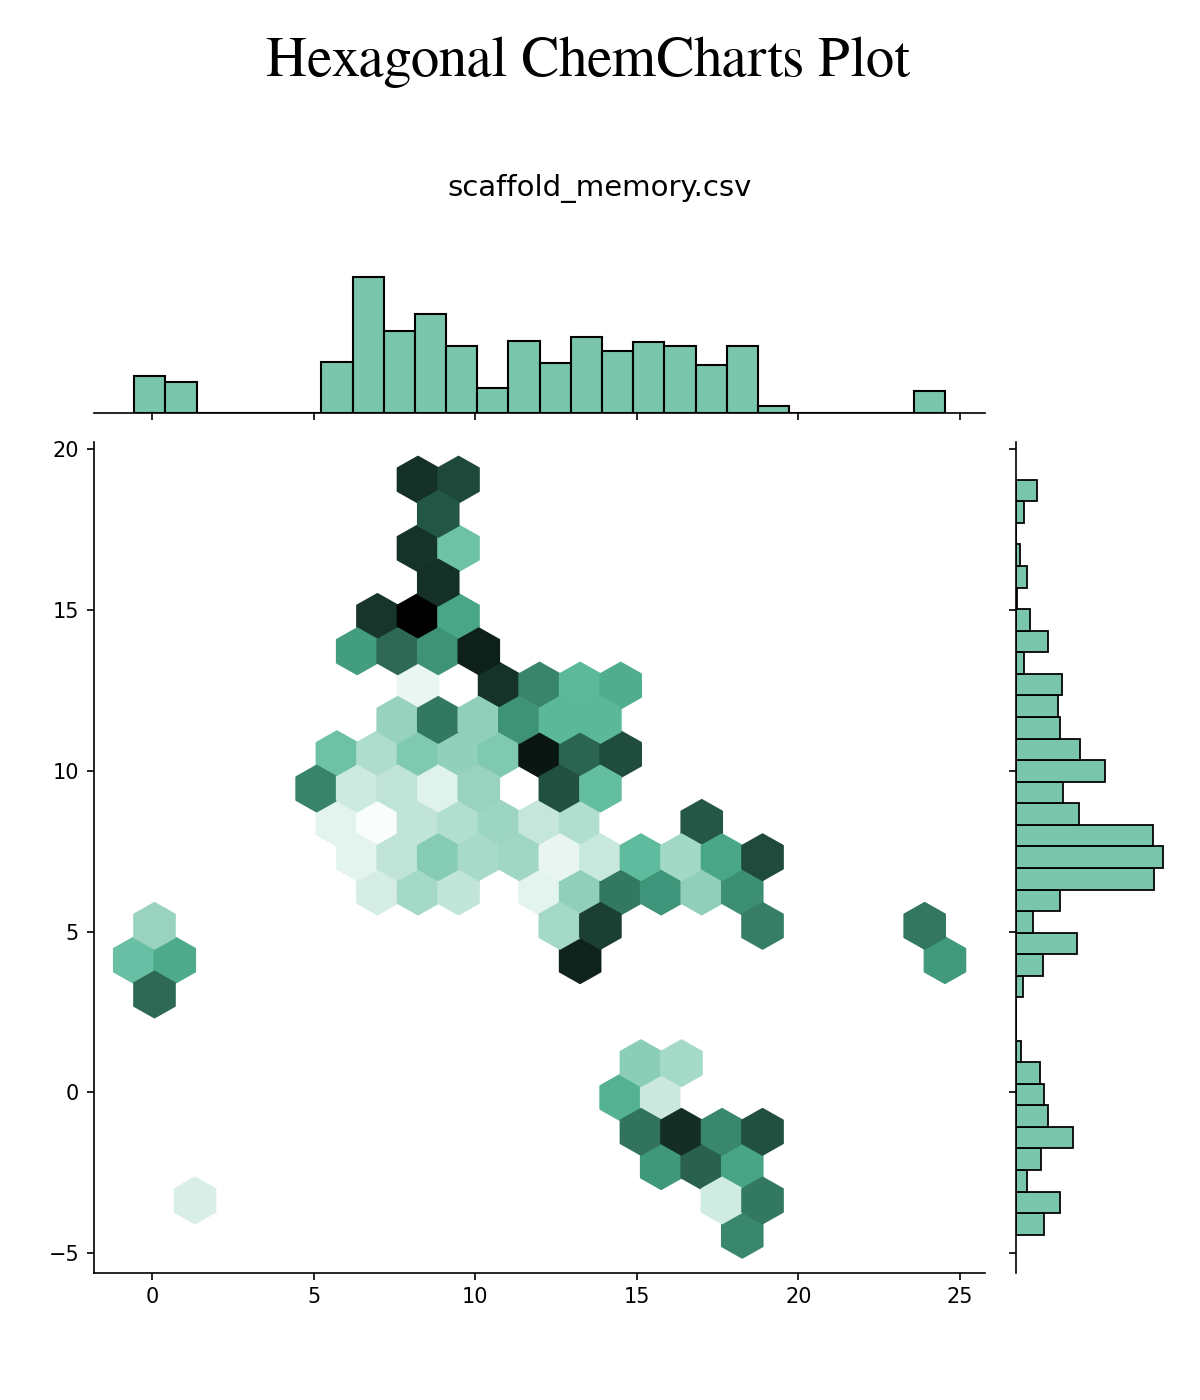

In [18]:

# display hexagonal plot 
Image(filename=os.path.join(output_dir, "hexagonal_plot.png"), width=400, height=200)      # with "width" and "height" the displayed 
                                                                                           # image size can be adjusted


### Example: Hexagonal plot generation with defined xlim and ylim
The parameters xlim and ylim allow to define an excerpt for the plot. 

CAUTION: When plots with multiple `ChemCharts` objects (datasets) are generated it might be advisable to start with an initial run where xlim and ylim are not set as this allows to visualize the different axes' ranges. In a second run xlim and ylim might be set to allow for coherent ranges.  

In [19]:

# plot generation with defined xlim and ylim
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",                                             
       "parameters":  {"title": "Hexagonal ChemCharts Plot",                 
                       "gridsize": 20,                                       
                       "fontsize": 14,                                        
                       "top": 0.9,
                       "color": "#4CB391",
                       "cross_object_normalize": True,                                           
                       "xlim": [-6.5, 14],                                            # set xlim  
                       "ylim": [-9, 12]},                                             # set ylim                     
        "settings": {"path": os.path.join(output_dir, "hexagonal_xlim_ylim_plot.png"), 
                     "format": "png",                                          
                     "dpi": 150,                                             
                     "figsize": [8, 8]}                                                                                  
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_hex_xlim_ylim_simple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}


Task data_loading completed.
None
Task generate_plot completed.


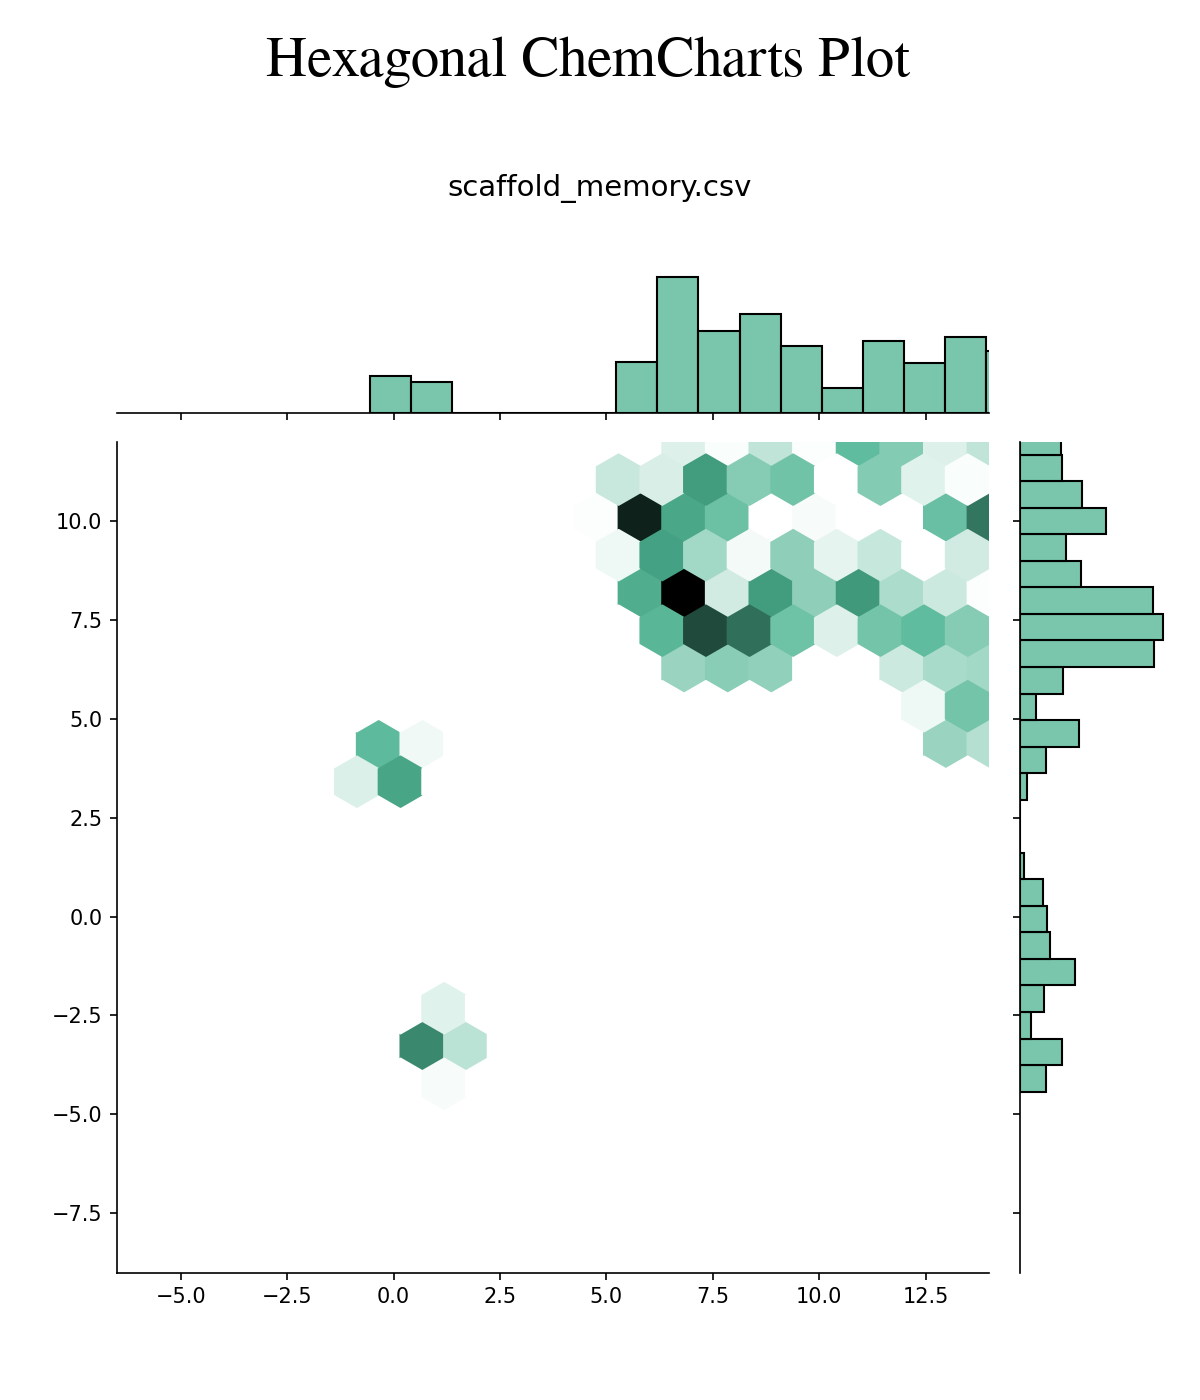

In [20]:

# display hexagonal plot with defined xlim and ylim
Image(filename=os.path.join(output_dir, "hexagonal_xlim_ylim_plot.png"), width=400, height=200)      # with "width" and "height" the  
                                                                                                     # displayed image size can be 
                                                                                                     # adjusted


It is advisable to always set `xlim` and `ylim` when plotting multiple chemdata objects (datasets) to ensure all subplots show the same excerpt (this example is generated with `multiple_plot_test.pkl`, other than that the code is similar to the one above):

In [21]:

# multiple dataset run of hexagonal plot with defined xlim and ylim
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "multiple_plot_test.pkl")],                  # change pkl to "multiple_plot_test.pkl"
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "hexagonal_plot",                                             
       "parameters":  {"title": "Hexagonal ChemCharts Plot",                 
                       "gridsize": 20,                                       
                       "fontsize": 14,                                        
                       "top": 0.9,                                               
                       "color": "#4CB391",                                   
                       "cross_object_normalize": True,
                       "xlim": [-6.5, 14],                                              # set xlim  
                       "ylim": [-9, 12]                                                 # set ylim
                       },                            
        "settings": {"path": os.path.join(output_dir, "hexagonal_plot_multiple.png"),   # you might want to change the  
                                                                                        # output file as well
                     "format": "png",                                          
                     "dpi": 150,                                             
                     "figsize": [8, 8]}                                       
      }
    ]
  }
}
 
# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_hex_xlim_ylim_multiple.json")   # as well as the JSON
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True) 
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}  


Task data_loading completed.
                                          comparison    cosine
0       scaffold_memory.csv_scaffold_memory_run2.csv  0.500644
1       scaffold_memory.csv_scaffold_memory_run3.csv  0.723524
2  scaffold_memory_run2.csv_scaffold_memory_run3.csv  0.534917
Task generate_plot completed.


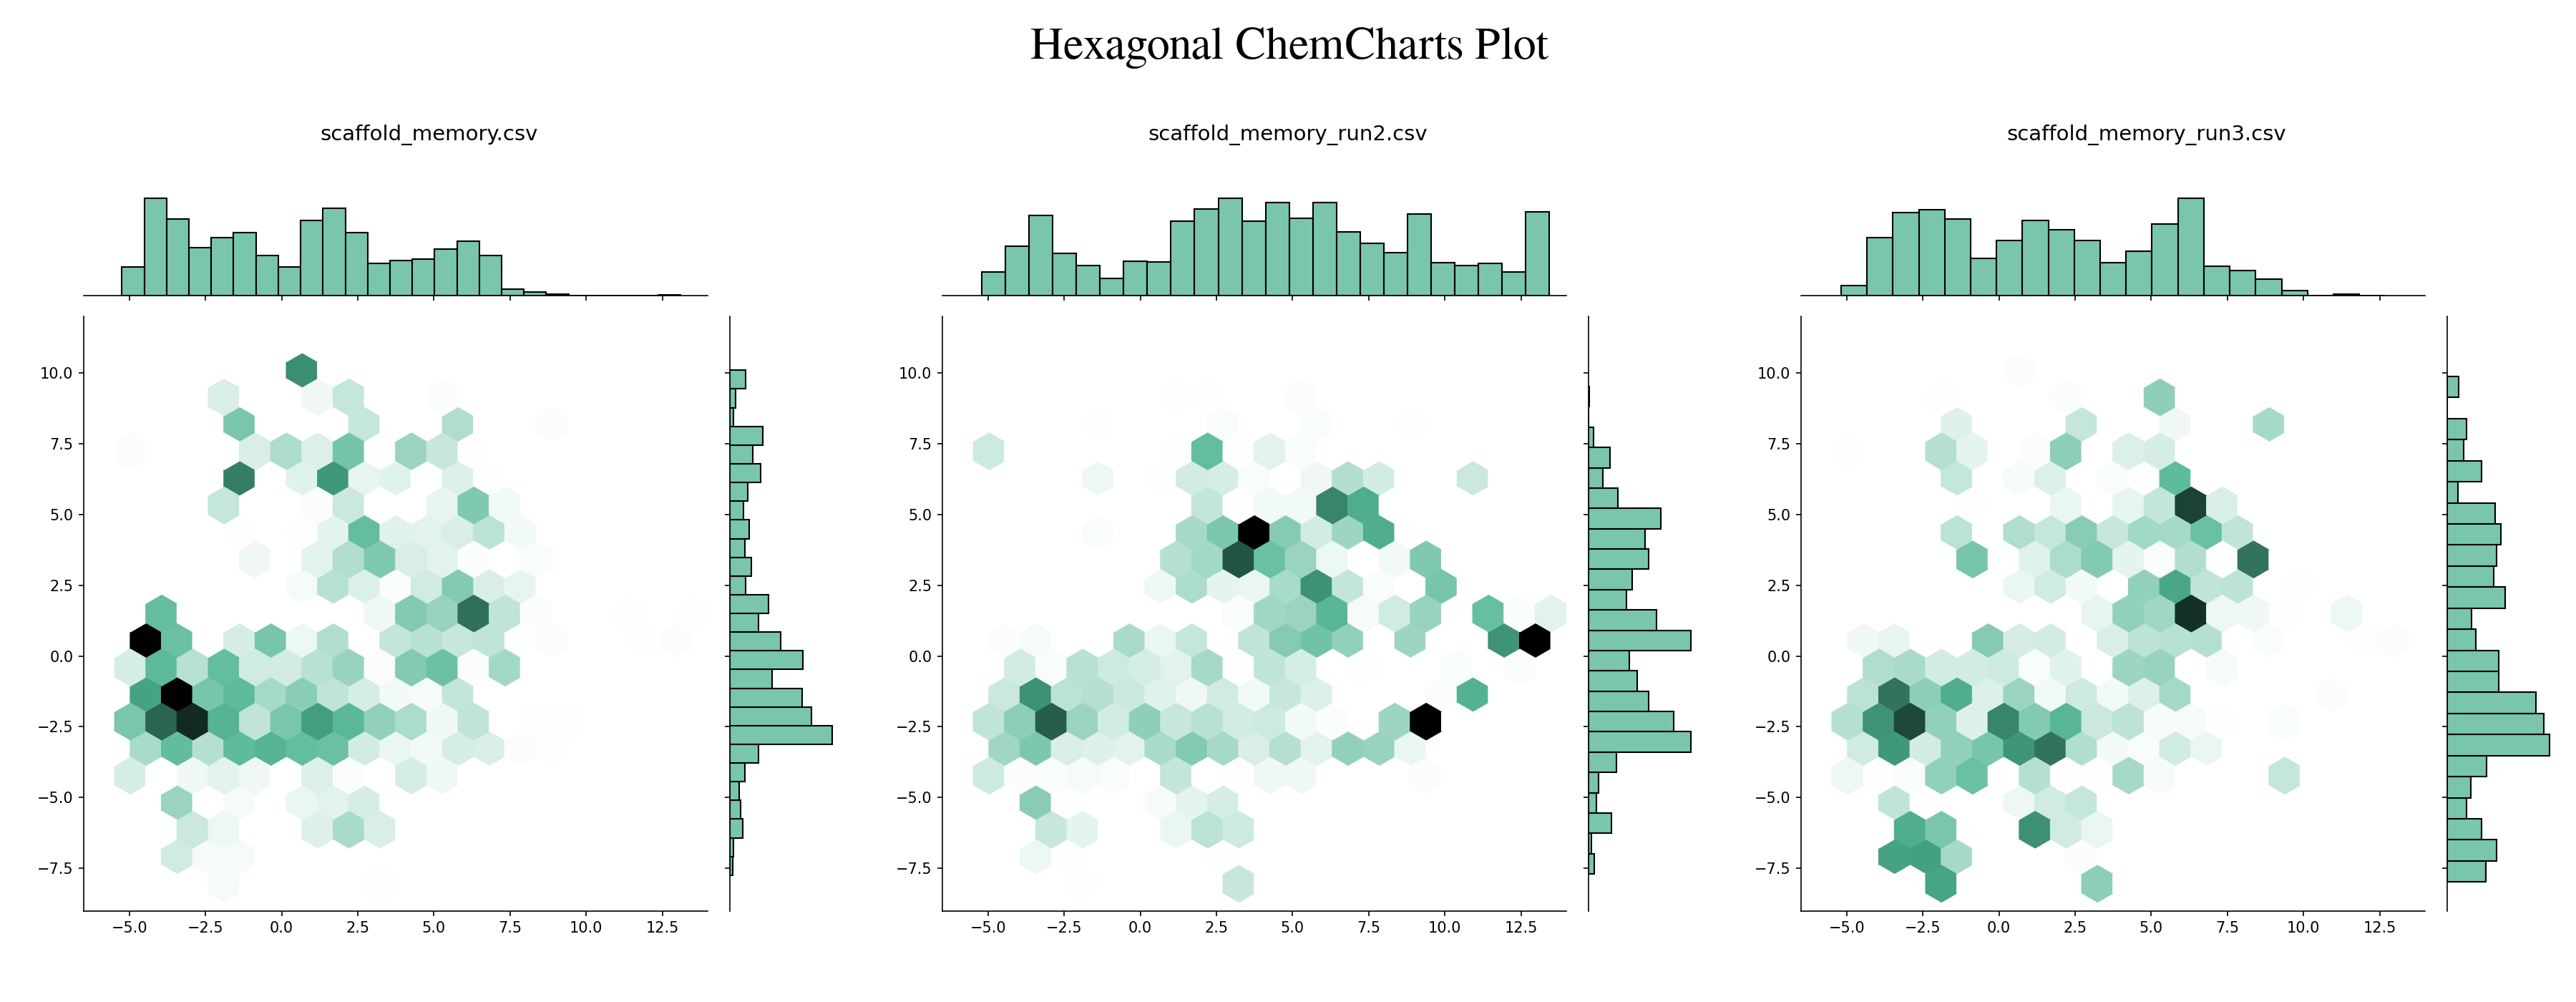

In [22]:

# display hexagonal plot (multiple datasets) 
Image(filename=os.path.join(output_dir, "hexagonal_plot_multiple.png"), width=1000, height=800)      # with "width" and "height" the 
                                                                                                     # displayed image size can be adjusted


### Example: Multiple plot generation
You can also generate multiple plots at once.

In [23]:

# generates a histogram and scatter interactive plot
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "histogram_plot",                                              # choose plot type (here: Histogram)
       "parameters":  {"title": "Histogram ChemCharts Plot",                  # set plot title (default: Histogram Chemcharts Plot)
                       "bins": 20,                                            # set bin number {default: 20}
                       "fontsize": 14,                                        # set font size of dataset title (default: 14) 
                       "top": 0.9,                                            # set top margin (default: 0.9)
                       "color": "#d11d80",                                    # set marker color with a hex color code 
                                                                              # (default: #d11d80)
                       "value_column": "total_score",                         # choose value for this plot
                       "value_name": "Scores"},                               # choose value name (will also be the y-axis title) 
       "settings": {"path": os.path.join(output_dir, "histogram_plot.png"),   # set output path including file name
                    "format": "png",                                          # set file format (default: png)  
                    "dpi": 300,                                               # set dpi (default: 300)
                    "figsize": [7, 7]}                                        # set figure size (default: [7, 7])
      },                                                                      # NOTE: a user defined xlim and ylim setting is not 
                                                                              # possible with a histogram plot          
      {"task": "generate_plot",
       "type": "scatter_interactive_plot",
       "parameters":  {"title": "Scatter Interactive ChemCharts Plot",                # set plot title (default: Scatter Interactive 
                                                                                      # Chemcharts Plot)
                       "marker_size": 1,                                              # set marker size (default: 1)
                       "xlim": [-6.5, 14],                                            # set xlim and ylim when plotting multiple 
                                                                                      # chemdata objects (datasets) to ensure all 
                                                                                      # subplots show the same excerpt
                       "ylim": [-9, 12],                                             
                       "value_column": "total_score",                                 # choose value for this plot
                       "value_name": "Scores"},                                       # choose value name (will also be the y-axis 
                                                                                      # as well as colorbar title)
       "settings": {"path": os.path.join(output_dir, "scatter_interactive_plot.png"), # set output path including file name
                    "view": True,                                                     # set on "True" if pop-up window is 
                                                                                      # desired (default: false)
                    "format": "png",                                                  # set file format (default: png) 
                    "figsize": [900, 900]}                                            # set figure size (default: [900, 900])
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_hist_scatter_interac_simple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}


Task data_loading completed.
Task generate_plot completed.
Scatter interactive function does not support multiple input objects. Proceeding with first object.
Task generate_plot completed.


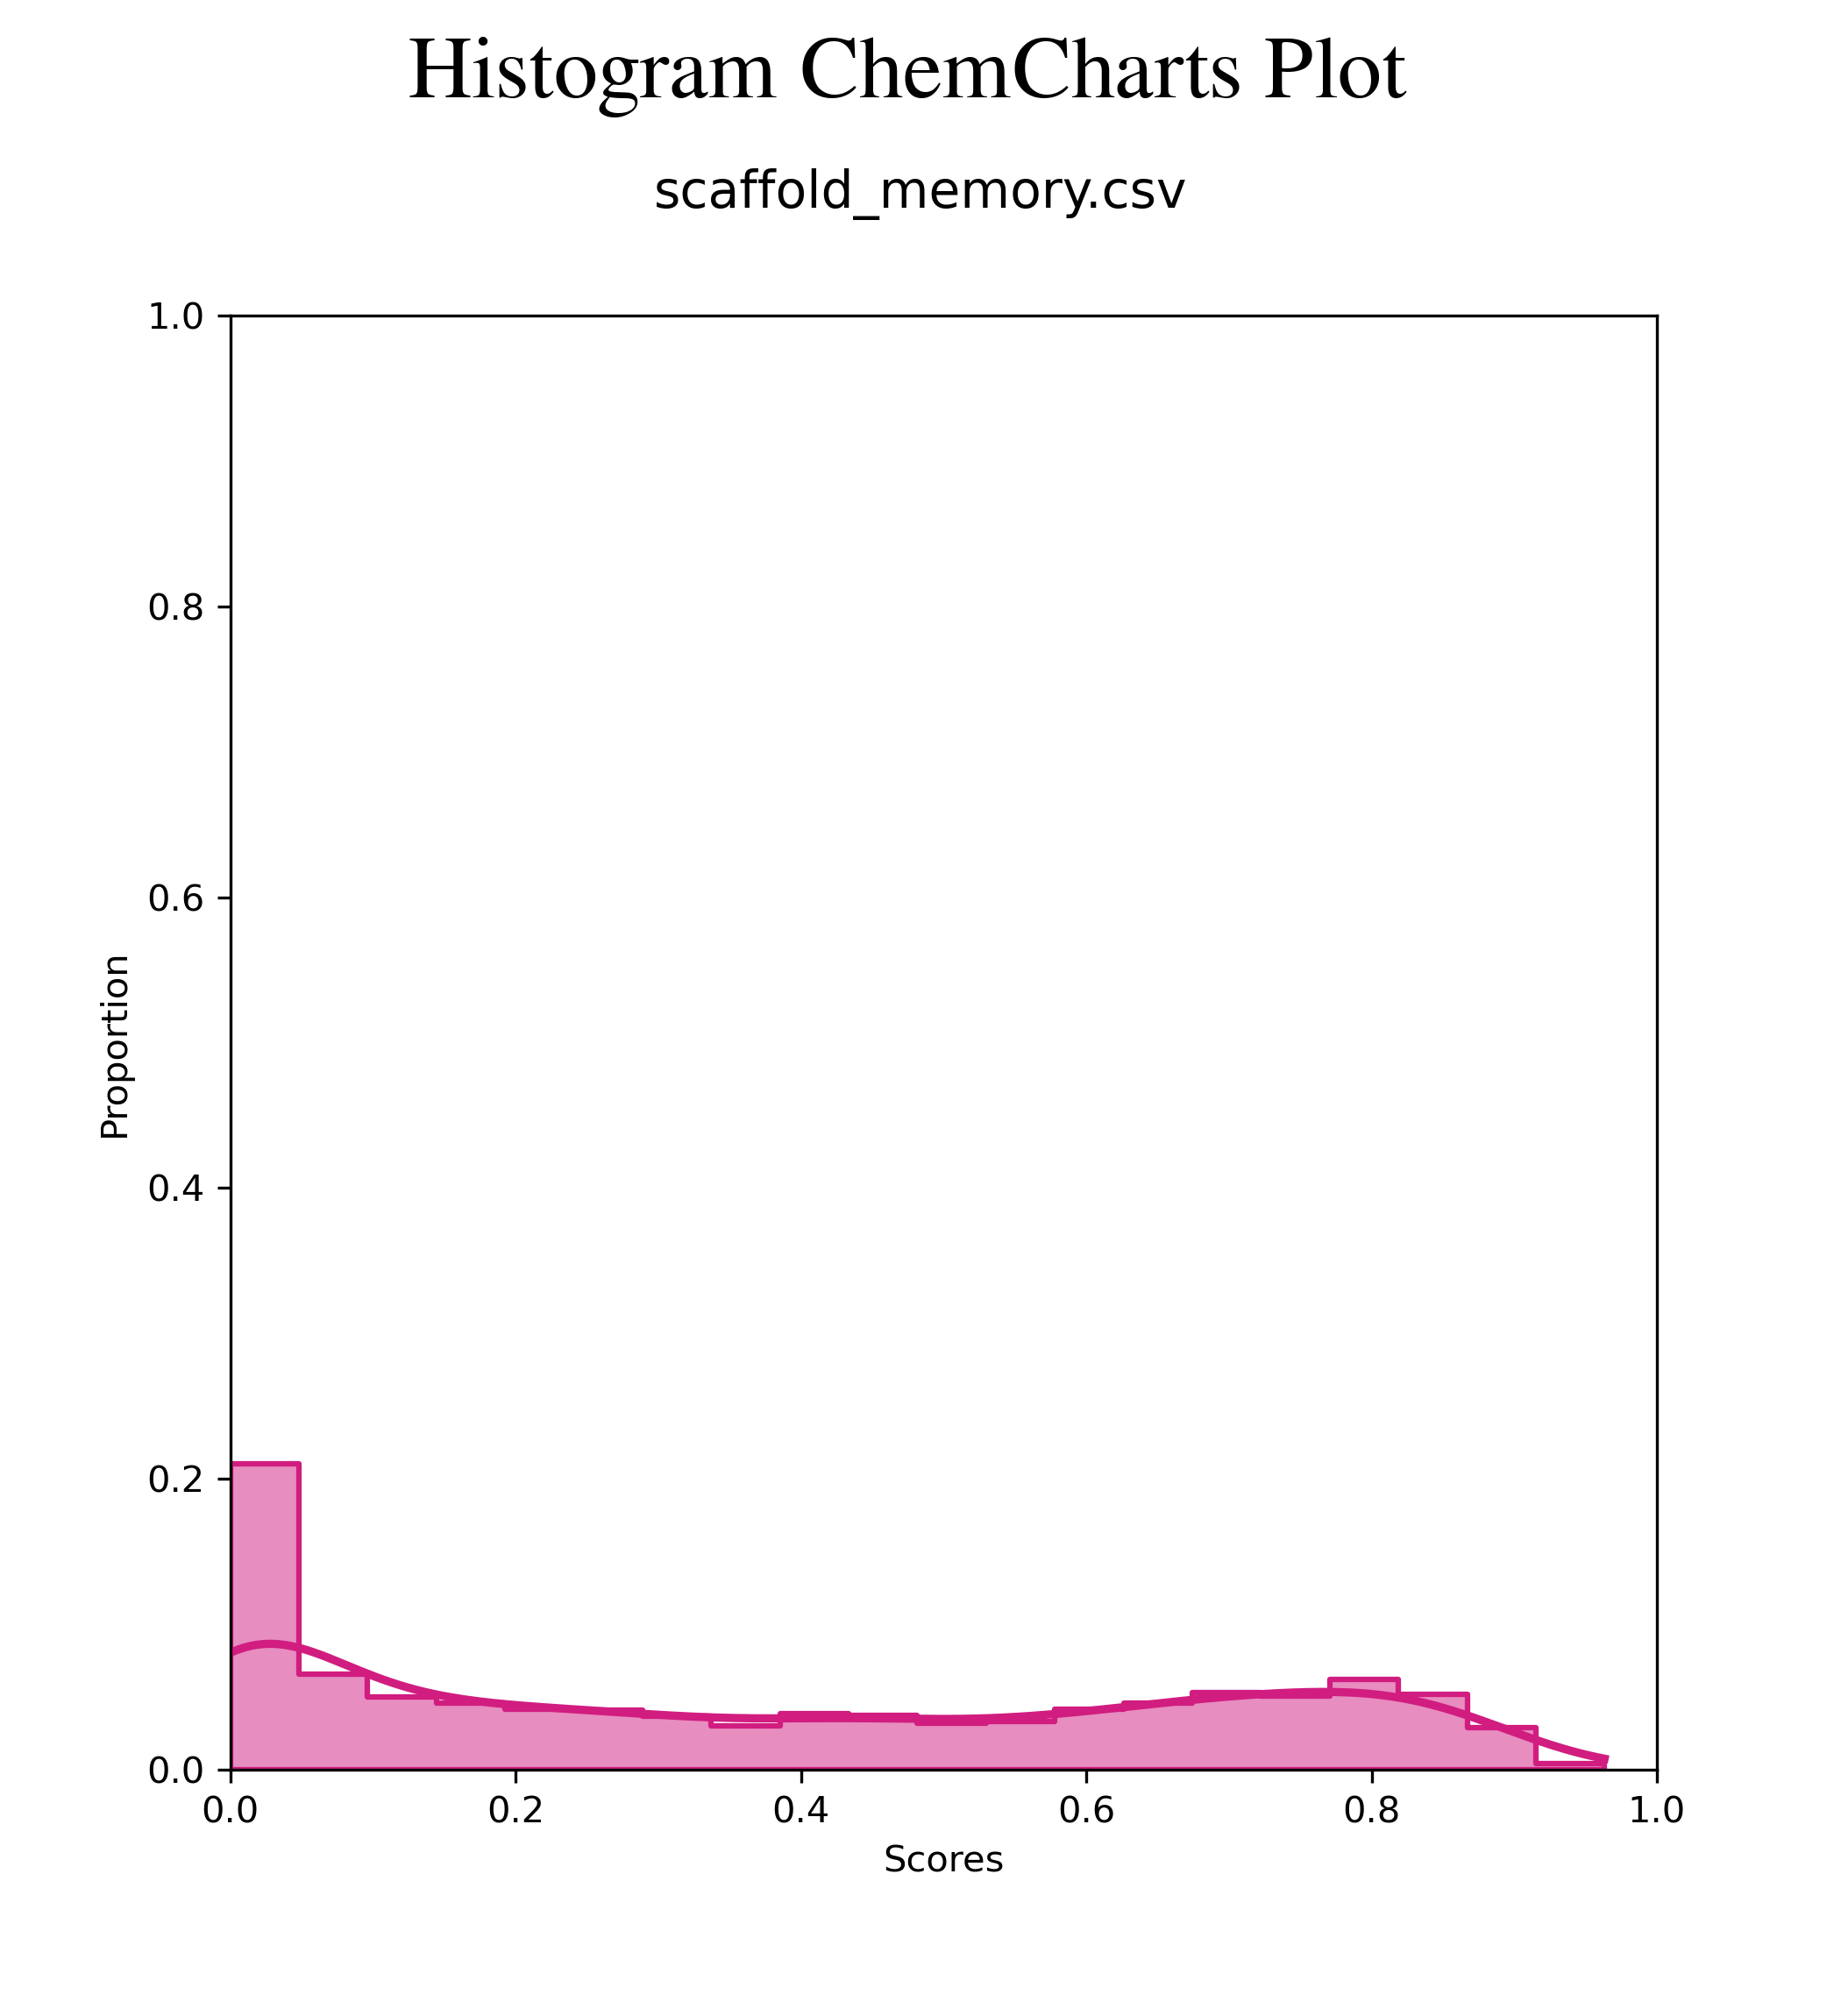

In [24]:

# display histogram plot
Image(filename=os.path.join(output_dir, "histogram_plot.png"), width=400, height=200)          # with "width" and "height" the  
                                                                                               # displayed image size can be 
                                                                                               # adjusted


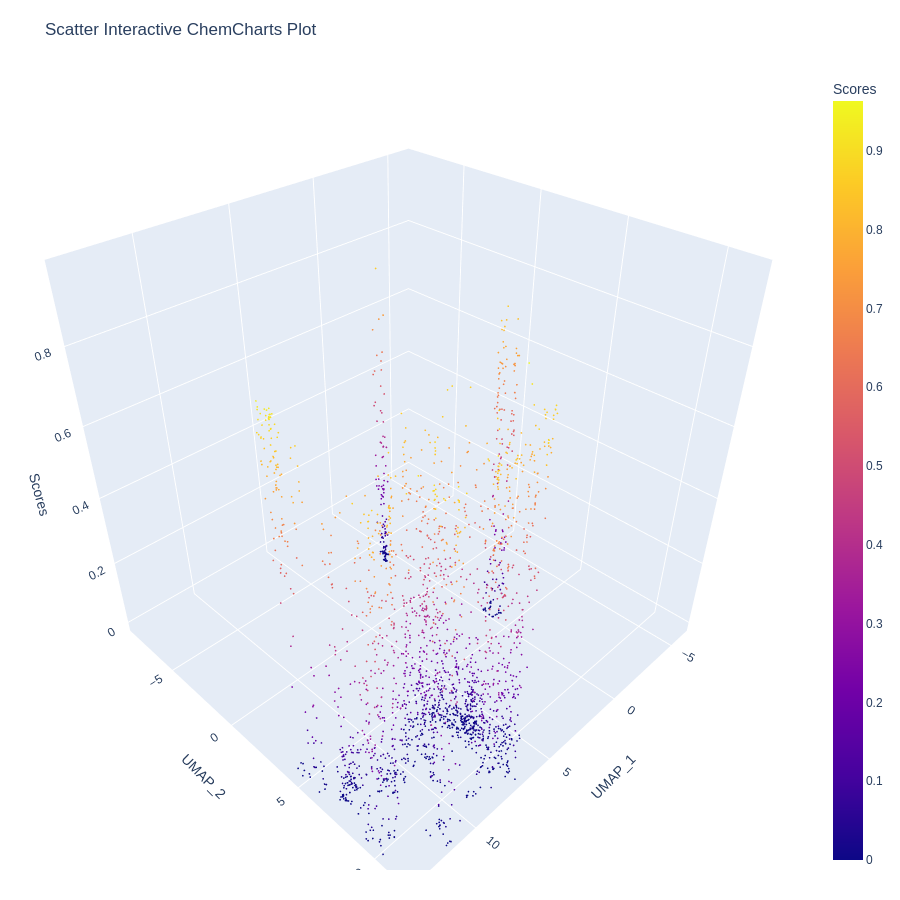

In [25]:

# display scatter_interactive plot
Image(filename=os.path.join(output_dir, "scatter_interactive_plot.png"), width=600, height=300)      # with "width" and "height" the  
                                                                                                     # displayed image size can be 
                                                                                                     # adjusted


### Example: Plot generation with different values
Adding multiple values when loading the data allows you to choose different values for different plots or compare values with the same plot type.

In [26]:

# generates two histogram plots (one with total_scores and one with QED Scores) 
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "histogram_plot",                                              
       "parameters":  {"title": "Total Score Histogram ChemCharts Plot",                  
                       "bins": 20,                                            
                       "fontsize": 14,                                         
                       "top": 0.9,                                            
                       "color": "#d11d80",                                    
                       "value_column": "total_score",                         # choose value for this plot
                       "value_name": "Total Scores"},                         # choose value name (will also be the y-axis title) 
       "settings": {"path": os.path.join(output_dir, "histogram_total_score_plot.png"),  
                    "format": "png",                                            
                    "dpi": 300,                                               
                    "figsize": [7, 7]}                                        
      },                                                                       
                                                                                        
      {"task": "generate_plot",
       "type": "histogram_plot",                                              
       "parameters":  {"title": "QED Score Histogram ChemCharts Plot",                  
                       "bins": 20,                                            
                       "fontsize": 14,                                         
                       "top": 0.9,                                            
                       "color": "#d11d80",                                    
                       "value_column": "QED Score",                           # choose value for this plot
                       "value_name": "QED Score"},                            # choose value name (will also be the y-axis title) 
       "settings": {"path": os.path.join(output_dir, "histogram_qed_score_plot.png"),   
                    "format": "png",                                          
                    "dpi": 300,                                               
                    "figsize": [7, 7]}                                        
      },                                                                       
                                                                                
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_hist_total_and_qed_score_simple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}


Task data_loading completed.
Task generate_plot completed.
Task generate_plot completed.


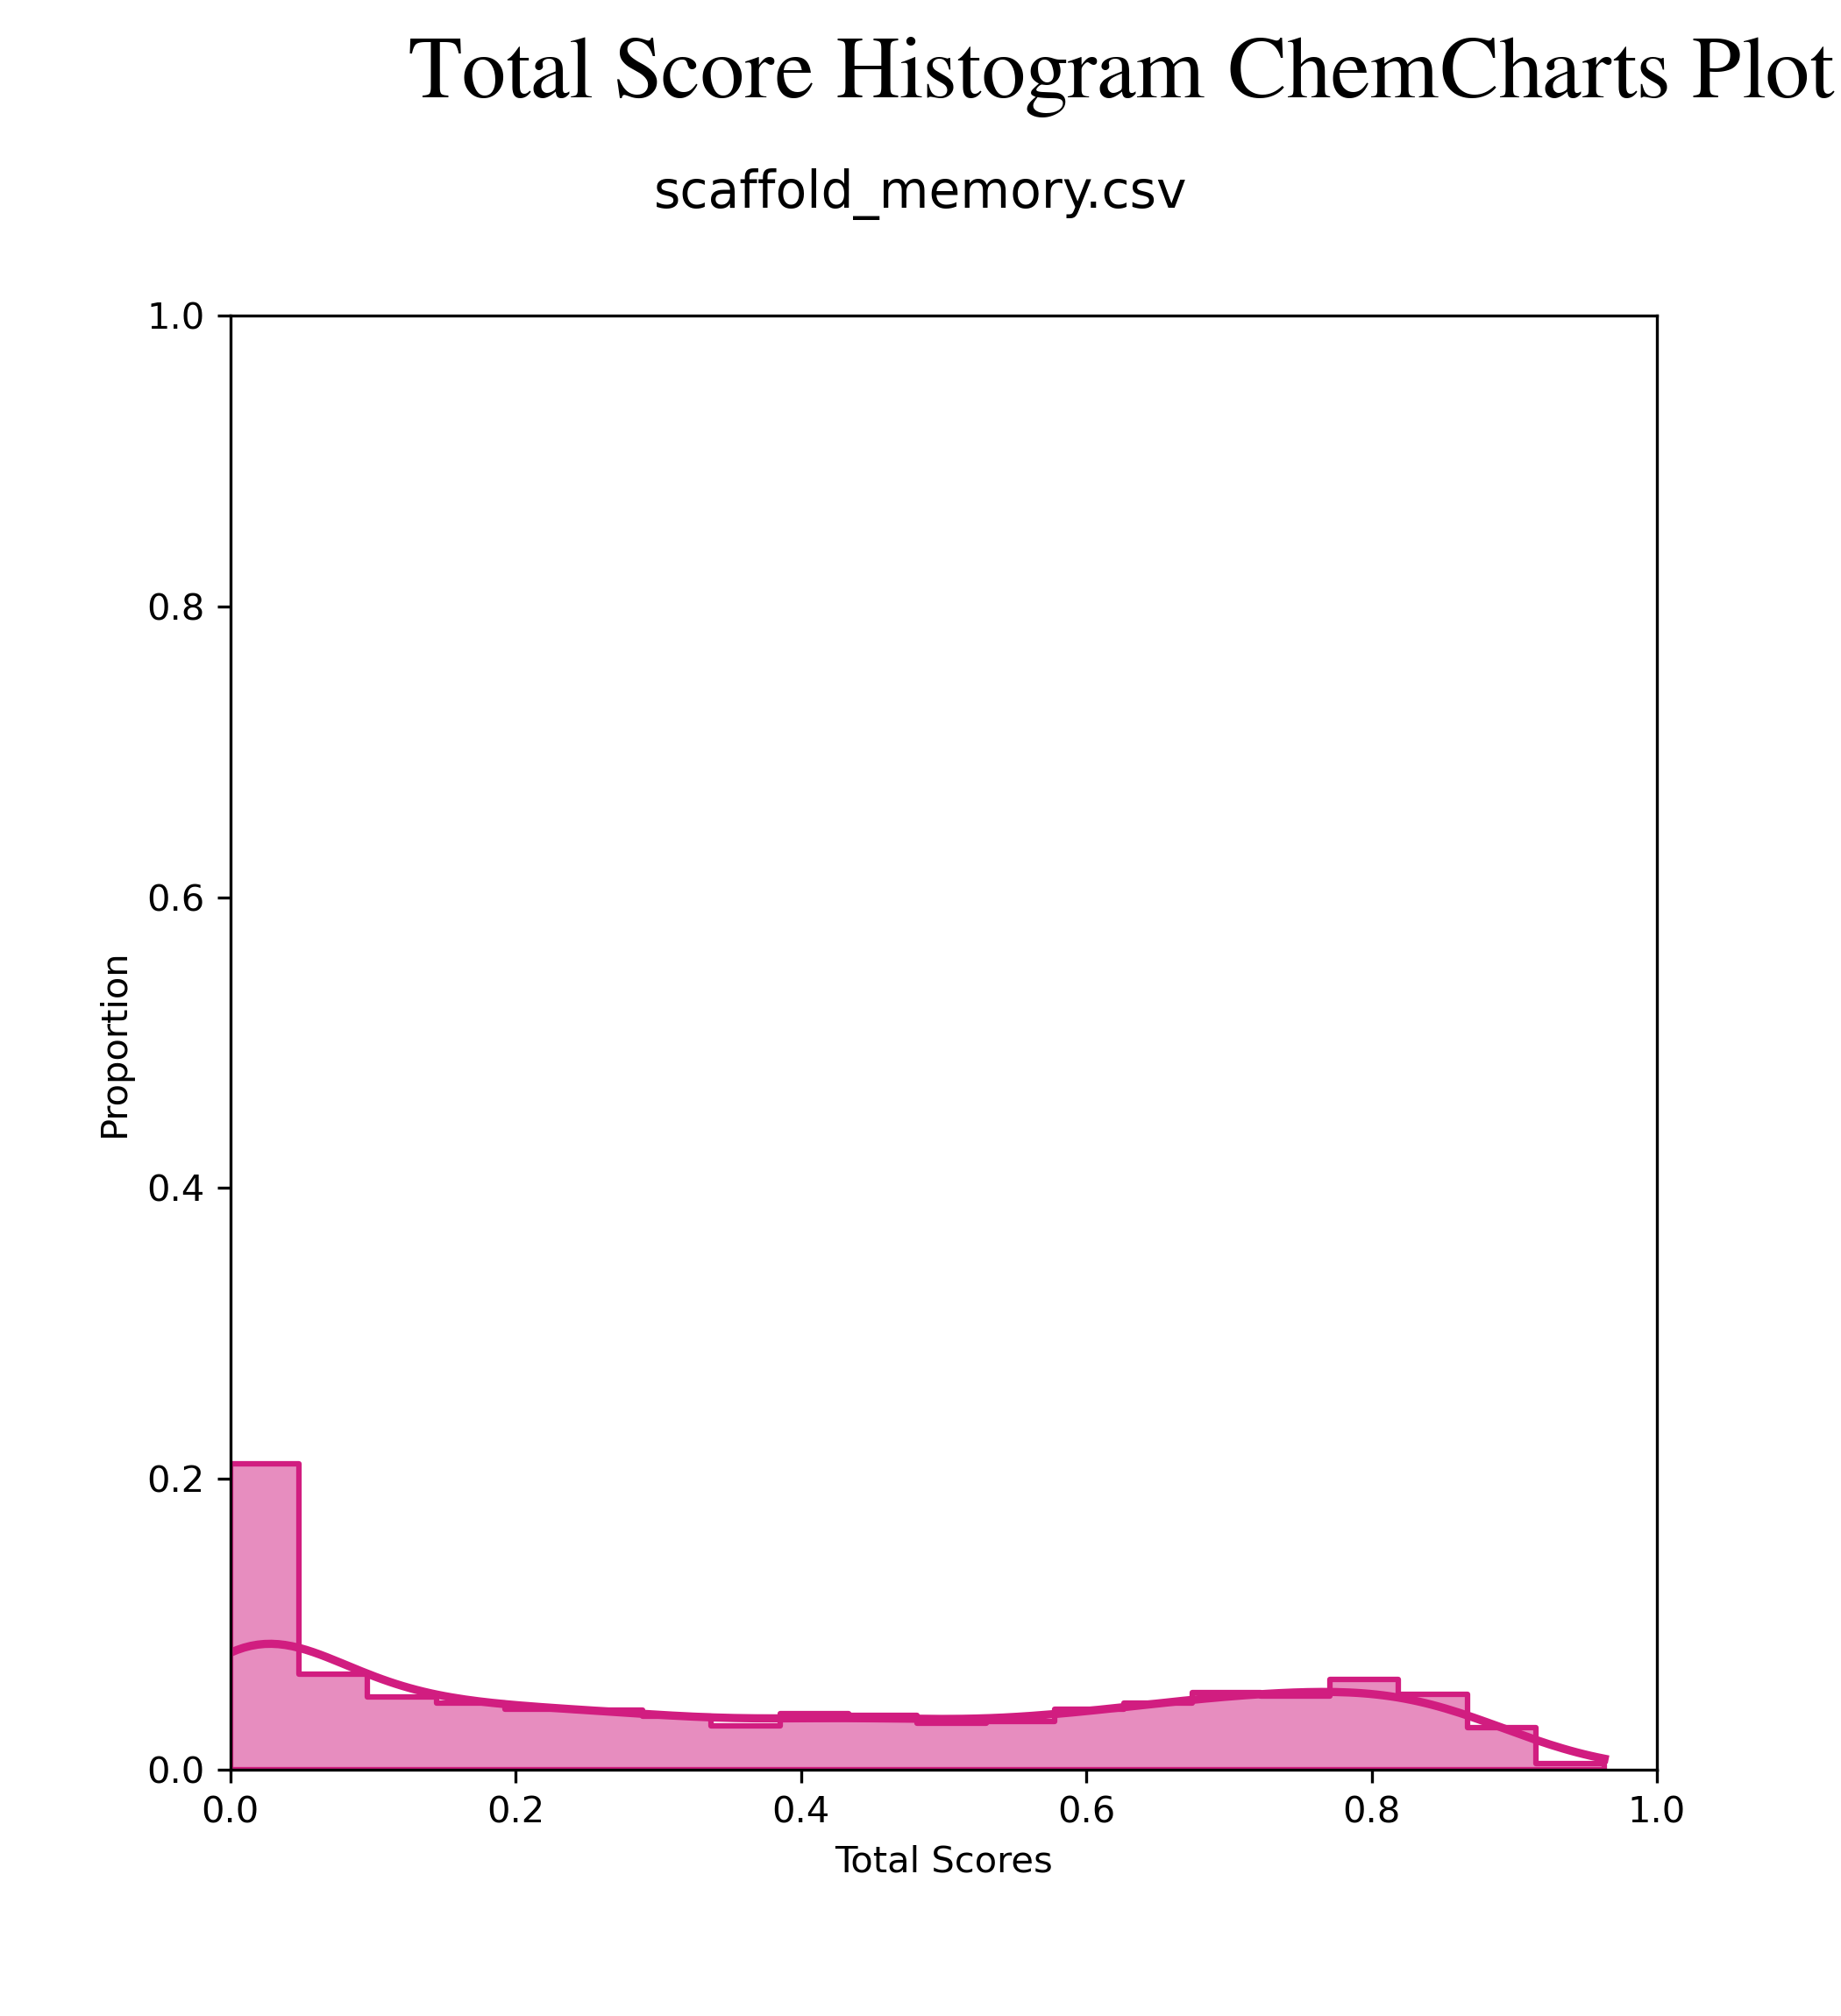

In [27]:

# display histogram plot with total_score value
Image(filename=os.path.join(output_dir, "histogram_total_score_plot.png"), width=400, height=200) # with "width" and "height"   
                                                                                                  # the displayed image size  
                                                                                                  # can be adjusted


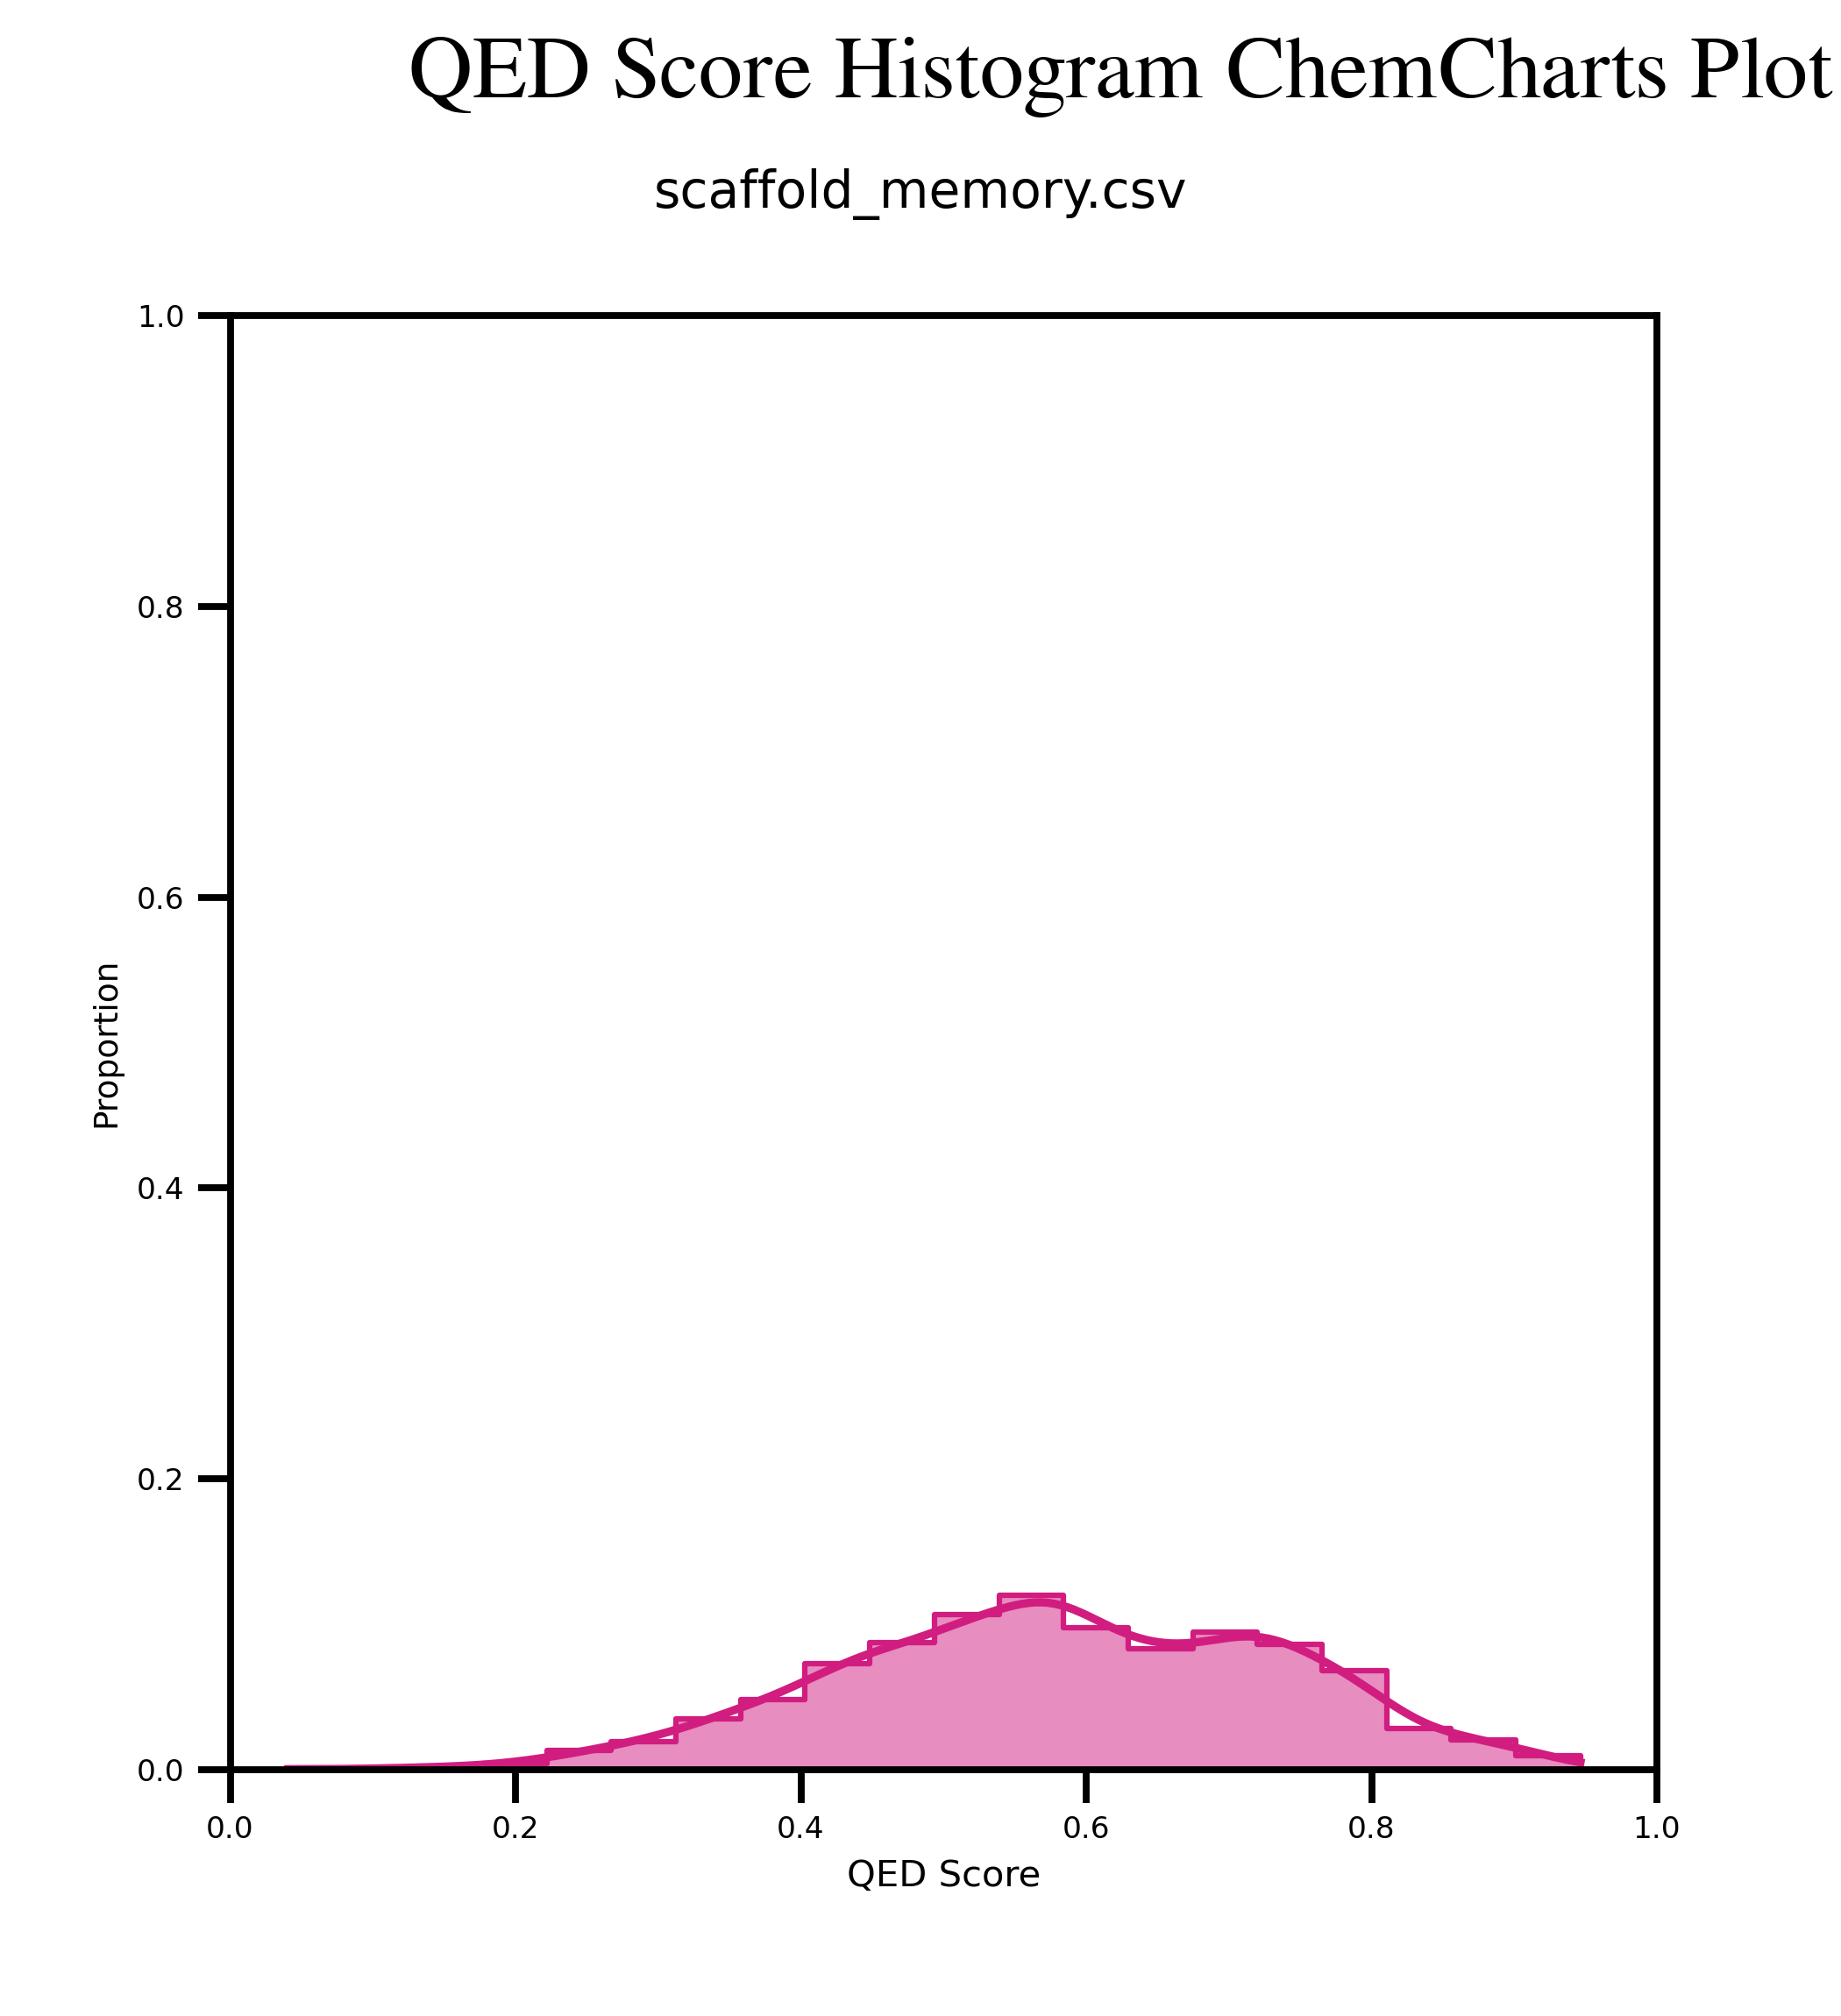

In [28]:

# display histogram plot with QED score value
Image(filename=os.path.join(output_dir, "histogram_qed_score_plot.png"), width=400, height=200) # with "width" and "height"   
                                                                                                # the displayed image size  
                                                                                                # can be adjusted



### Example: Scatter boxplot generation with different modes
This scatter plot allows not only for an optional boxplot setting but for three different plotting modes as well. With the `plain` mode the scatter plot shows no difference in the coloring for individual data points. `groups` allows for coloring according to the given groups e.g. patent groups, mol types etc. which have to be provided in a column of the input file (see "scaffold_memory_groups.csv" in the data folder for reference). The legend name can be set with `group_legend_name`. Last but not least, `scores` connects the plot colors to the scores which can also be user defined by setting `vmin` and `vmax` (default will be the min and max values of the given scores). 

Task data_loading completed.
Task generate_plot completed.


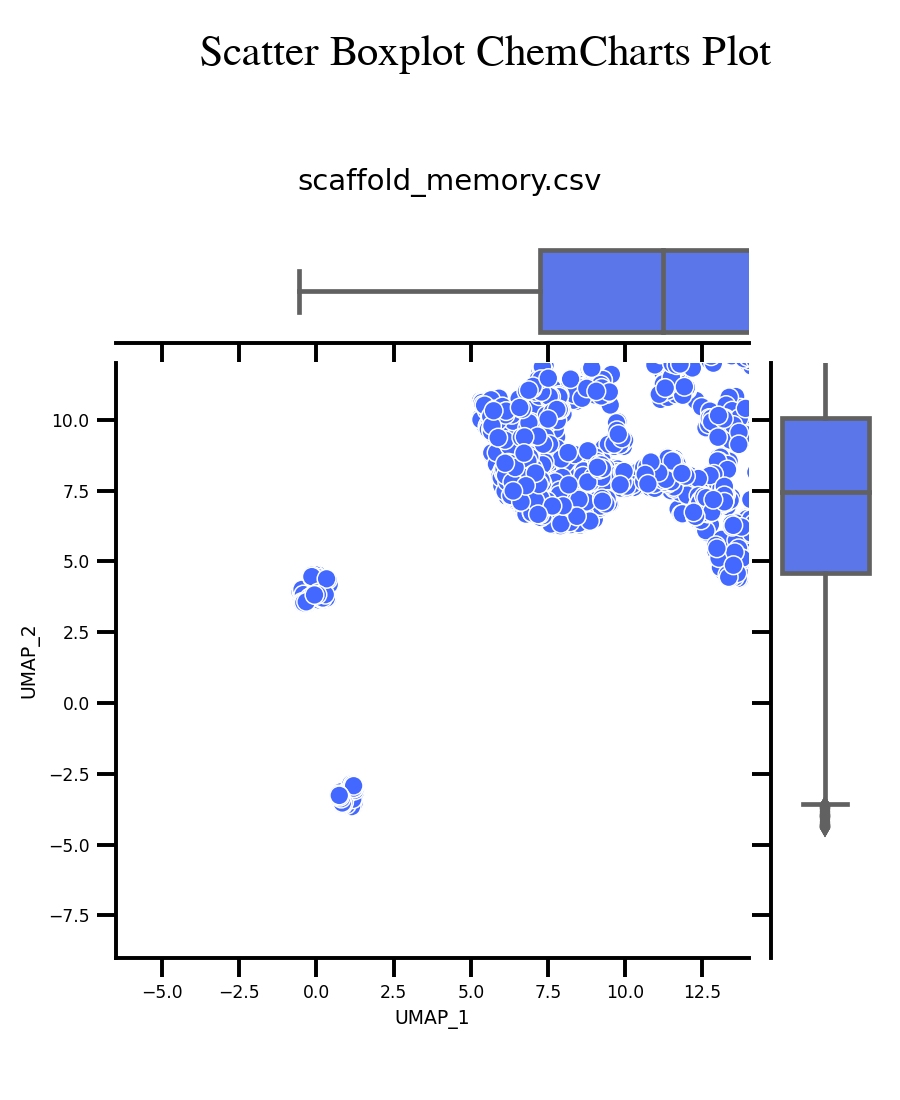

In [29]:

# generates a scatter boxplot in "plain" mode and "simple_plot_test.pkl"
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "scatter_boxplot_plot",
       "parameters":  {"title": "Scatter Boxplot ChemCharts Plot",                   # set plot title 
                                                                                     # (default: Scatter Boxplot Chemcharts Plot)
                       "fontsize": 14,                                               # set font size of dataset title (default: 14) 
                       "top": 0.9,                                                   # set top margin (default: 0.9)
                       "color": "#4368ff",                                           # set marker color with a hex color code or 
                                                                                     # color name e.g. "green" (default: "#4368ff") 
                       "mode": "plain",                                              # choose "plain", "value" or "groups" mode 
                                                                                     # (default: plain)   
                       "vmin": 0.8,                                                  # set min value for scores (default: min value 
                                                                                     # of given scores)
                       "vmax": 1,                                                    # set max value for scores (default: max value 
                                                                                     # of given scores)
                       "xlim": [-6.5, 14],                                           # set xlim and ylim when plotting multiple 
                                                                                     # chemdata objects (datasets) to ensure all
                                                                                     # subplots show the same excerpt
                       "ylim": [-9, 12],
                       "value_column": "total_score",                                # choose value for this plot
                       "value_name": "Total Scores"},                                # choose value name (will also be the y-axis title) 
        "settings": {"path": os.path.join(output_dir, "scatter_boxplot_plain.png"),  # set output path including file name
                     "format": "png",                                                # set file format (default: png) 
                     "dpi": 150,                                                     # set dpi (default: 150)
                     "figsize": [6, 6],                                              # set figure size (default: [6, 6])
                     "boxplot": True}                                                # set on "True" if setting is desired 
                                                                                     # (default: false)
        }    
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_boxplot_plain_simple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}

# display
Image(filename=os.path.join(output_dir, "scatter_boxplot_plain.png"), width=400, height=200)      # with "width" and "height" the 
                                                                                                  # displayed image size can be 
                                                                                                  # adjusted     


Task data_loading completed.
Task generate_plot completed.


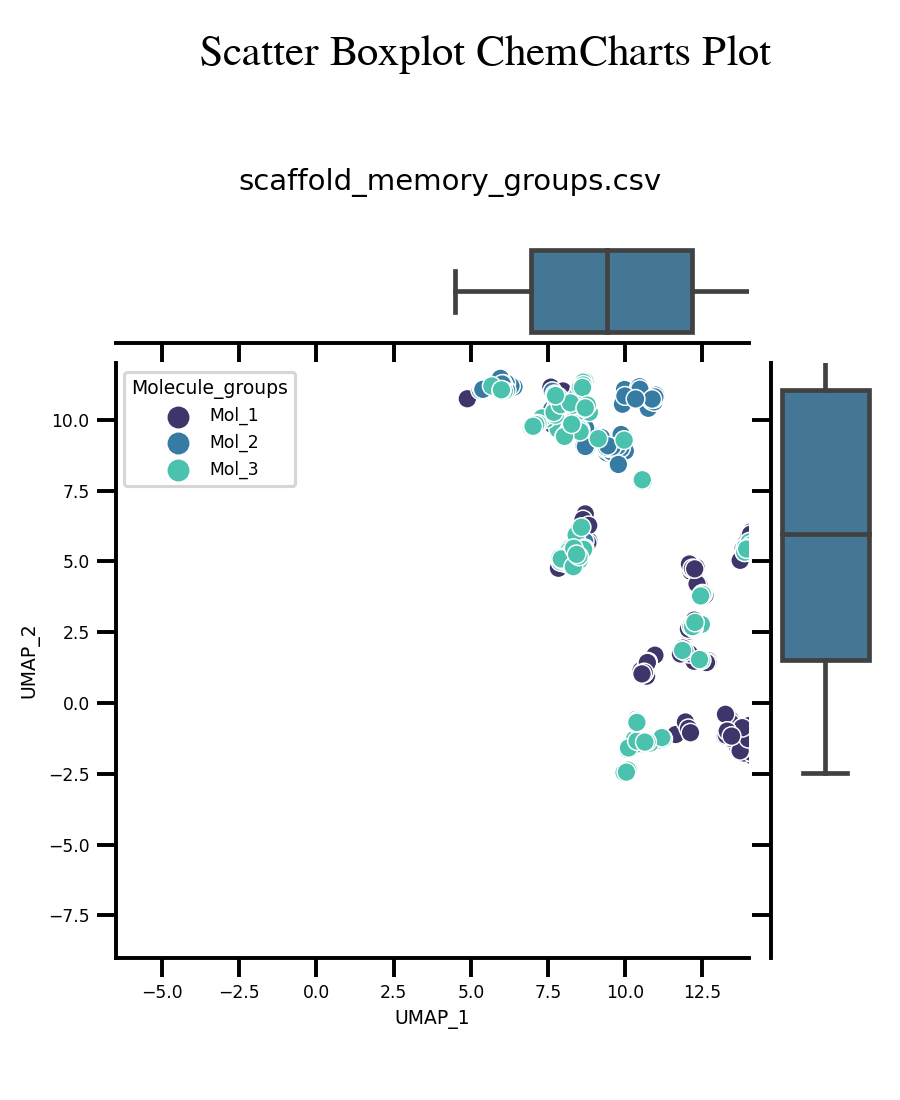

In [30]:

# generates a scatter boxplot in "groups" mode and "groups_plot_test.pkl"
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "groups_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "scatter_boxplot_plot",
       "parameters":  {"title": "Scatter Boxplot ChemCharts Plot",                   
                       "fontsize": 14,                                                
                       "top": 0.9,                                                   
                       "color": "mako",                                              # set marker color with a seaborn color 
                                                                                     # palette (default: mako) 
                       "group_legend_name": "Molecule_groups",                       # choose legend name for group colouring 
                                                                                     # (default: groups)  
                       "mode": "groups",                                             # choose "plain", "value" or "groups" mode 
                                                                                     # (default: plain)   
                       "vmin": 0.8,                                                  
                       "vmax": 1,                                                    
                       "xlim": [-6.5, 14],                                           
                       "ylim": [-9, 12],
                       "value_column": "total_score",                         
                       "value_name": "Total Scores"},                         
        "settings": {"path": os.path.join(output_dir, "scatter_boxplot_groups.png"), 
                     "format": "png",                                                 
                     "dpi": 150,                                                     
                     "figsize": [6, 6],                                              
                     "boxplot": True}                                                
        }    
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_boxplot_groups_groups.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}

# display 
Image(filename=os.path.join(output_dir, "scatter_boxplot_groups.png"), width=400, height=200)          


Task data_loading completed.
Task generate_plot completed.


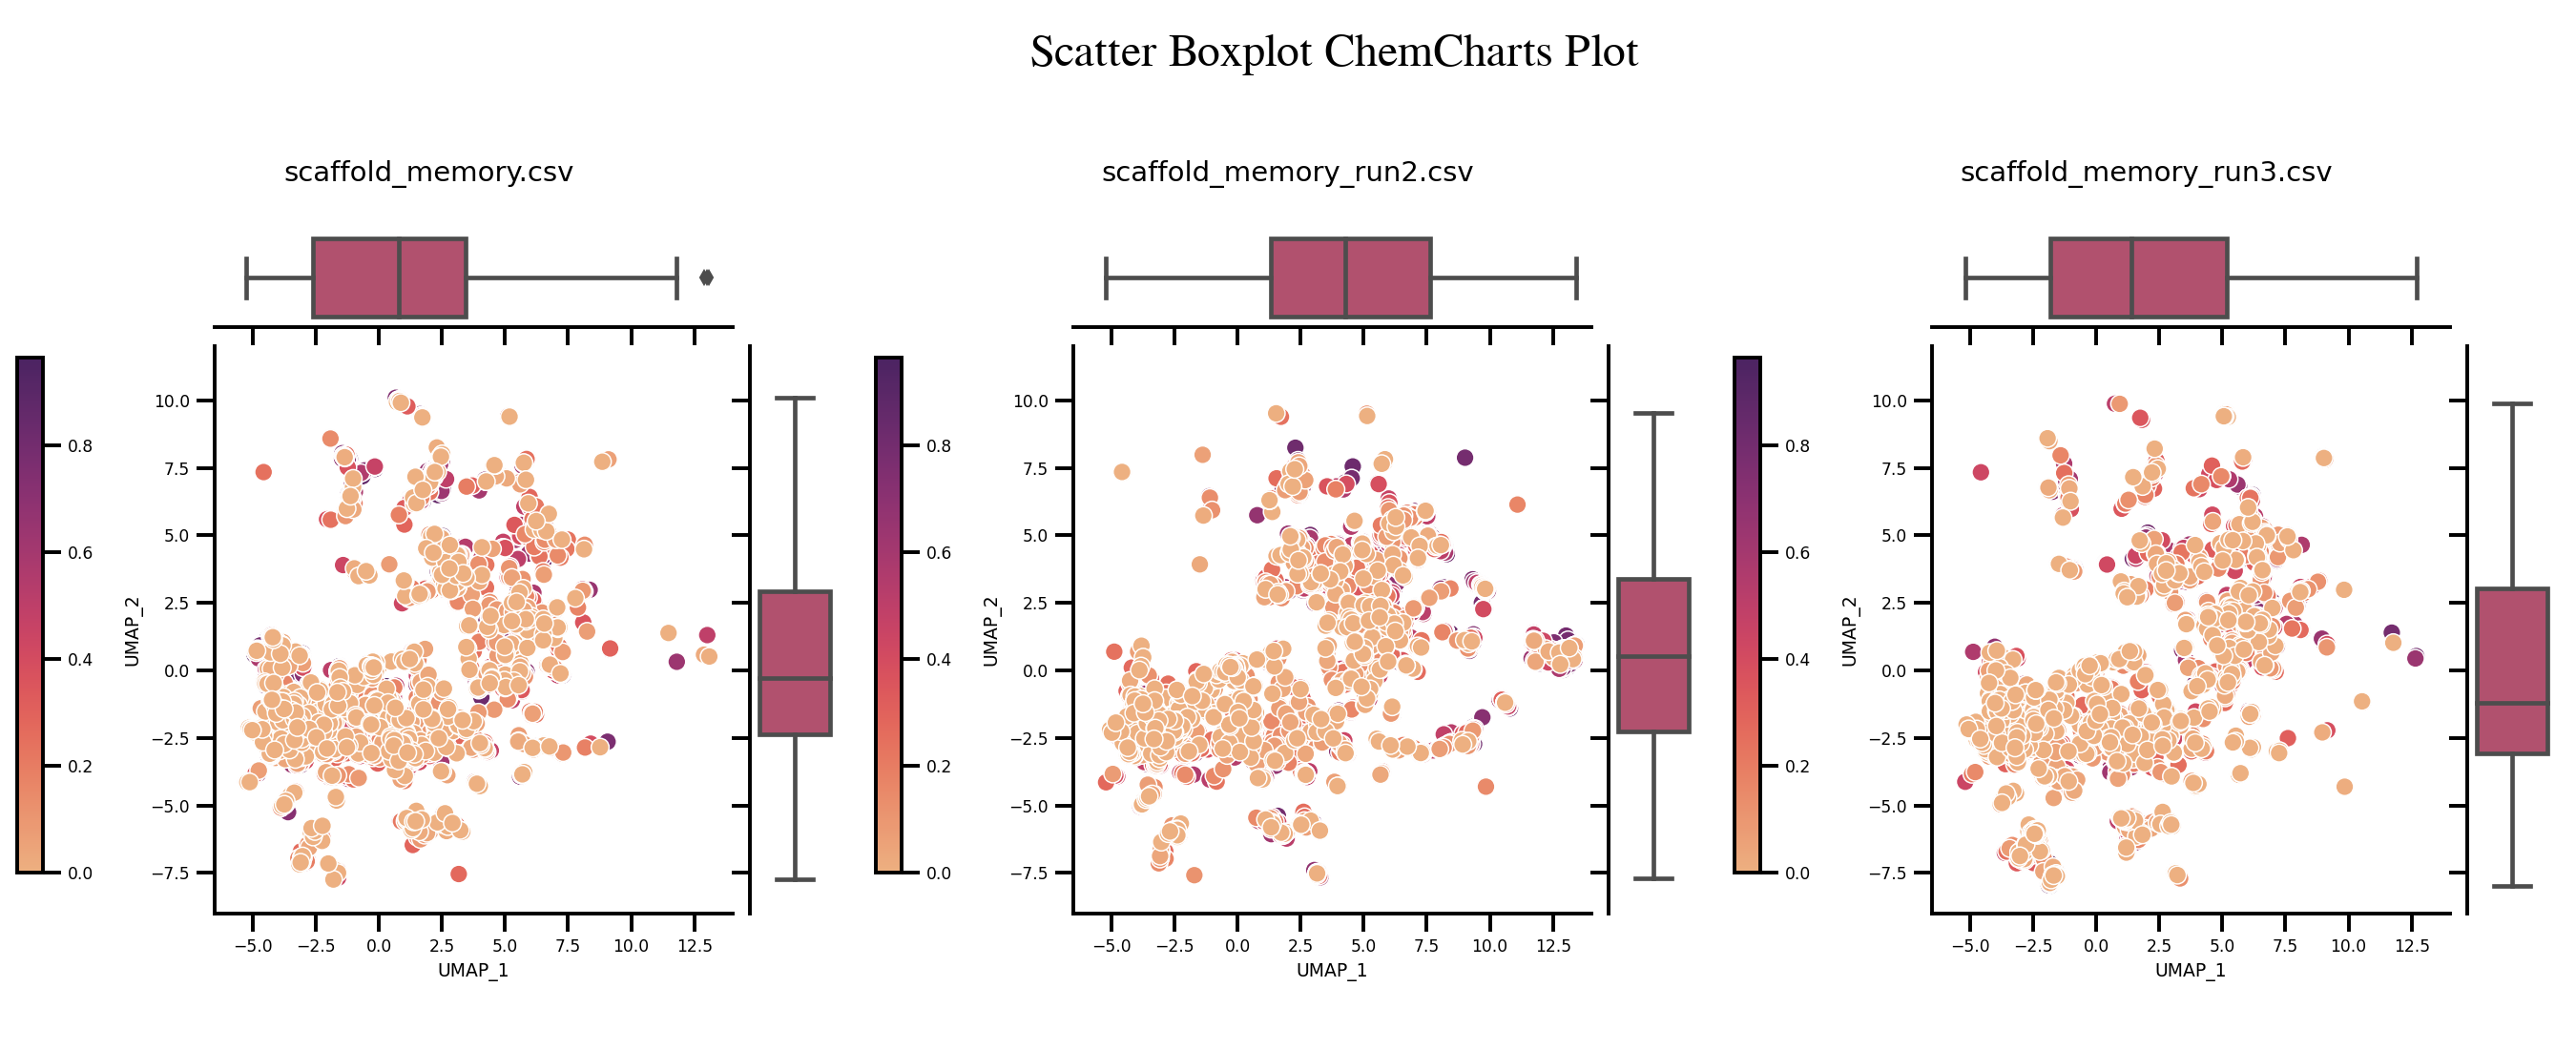

In [31]:

# generates a scatter boxplot in "value" mode and "multiple_plot_test.pkl"
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "multiple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "scatter_boxplot_plot",
       "parameters":  {"title": "Scatter Boxplot ChemCharts Plot",                   
                       "fontsize": 14,                                                
                       "top": 0.9,                                                   
                       "color": "flare",                                             # set marker color with a seaborn color 
                                                                                     # palette (default: flare)   
                       "mode": "value",                                              # choose "plain", "value" or "groups" mode 
                                                                                     # (default: plain)   
                       "vmin": 0,                                                  
                       "vmax": 1,                                                    
                       "xlim": [-6.5, 14],                                           
                       "ylim": [-9, 12],
                       "value_column": "total_score",                         
                       "value_name": "Total Scores"},                                            
        "settings": {"path": os.path.join(output_dir, "scatter_boxplot_scores.png"), 
                     "format": "png",                                                 
                     "dpi": 150,                                                     
                     "figsize": [6, 6],                                              
                     "boxplot": True}                                                
        }    
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_boxplot_scores_multiple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}

# display 
Image(filename=os.path.join(output_dir, "scatter_boxplot_scores.png"), width=1000, height=800)      # with "width" and "height" 
                                                                                                    # the displayed image size can be 
                                                                                                    # adjusted     


## PLOT VARIANTS
Other plot variants `ChemCharts` can generate: 

Task data_loading completed.
Task generate_plot completed.


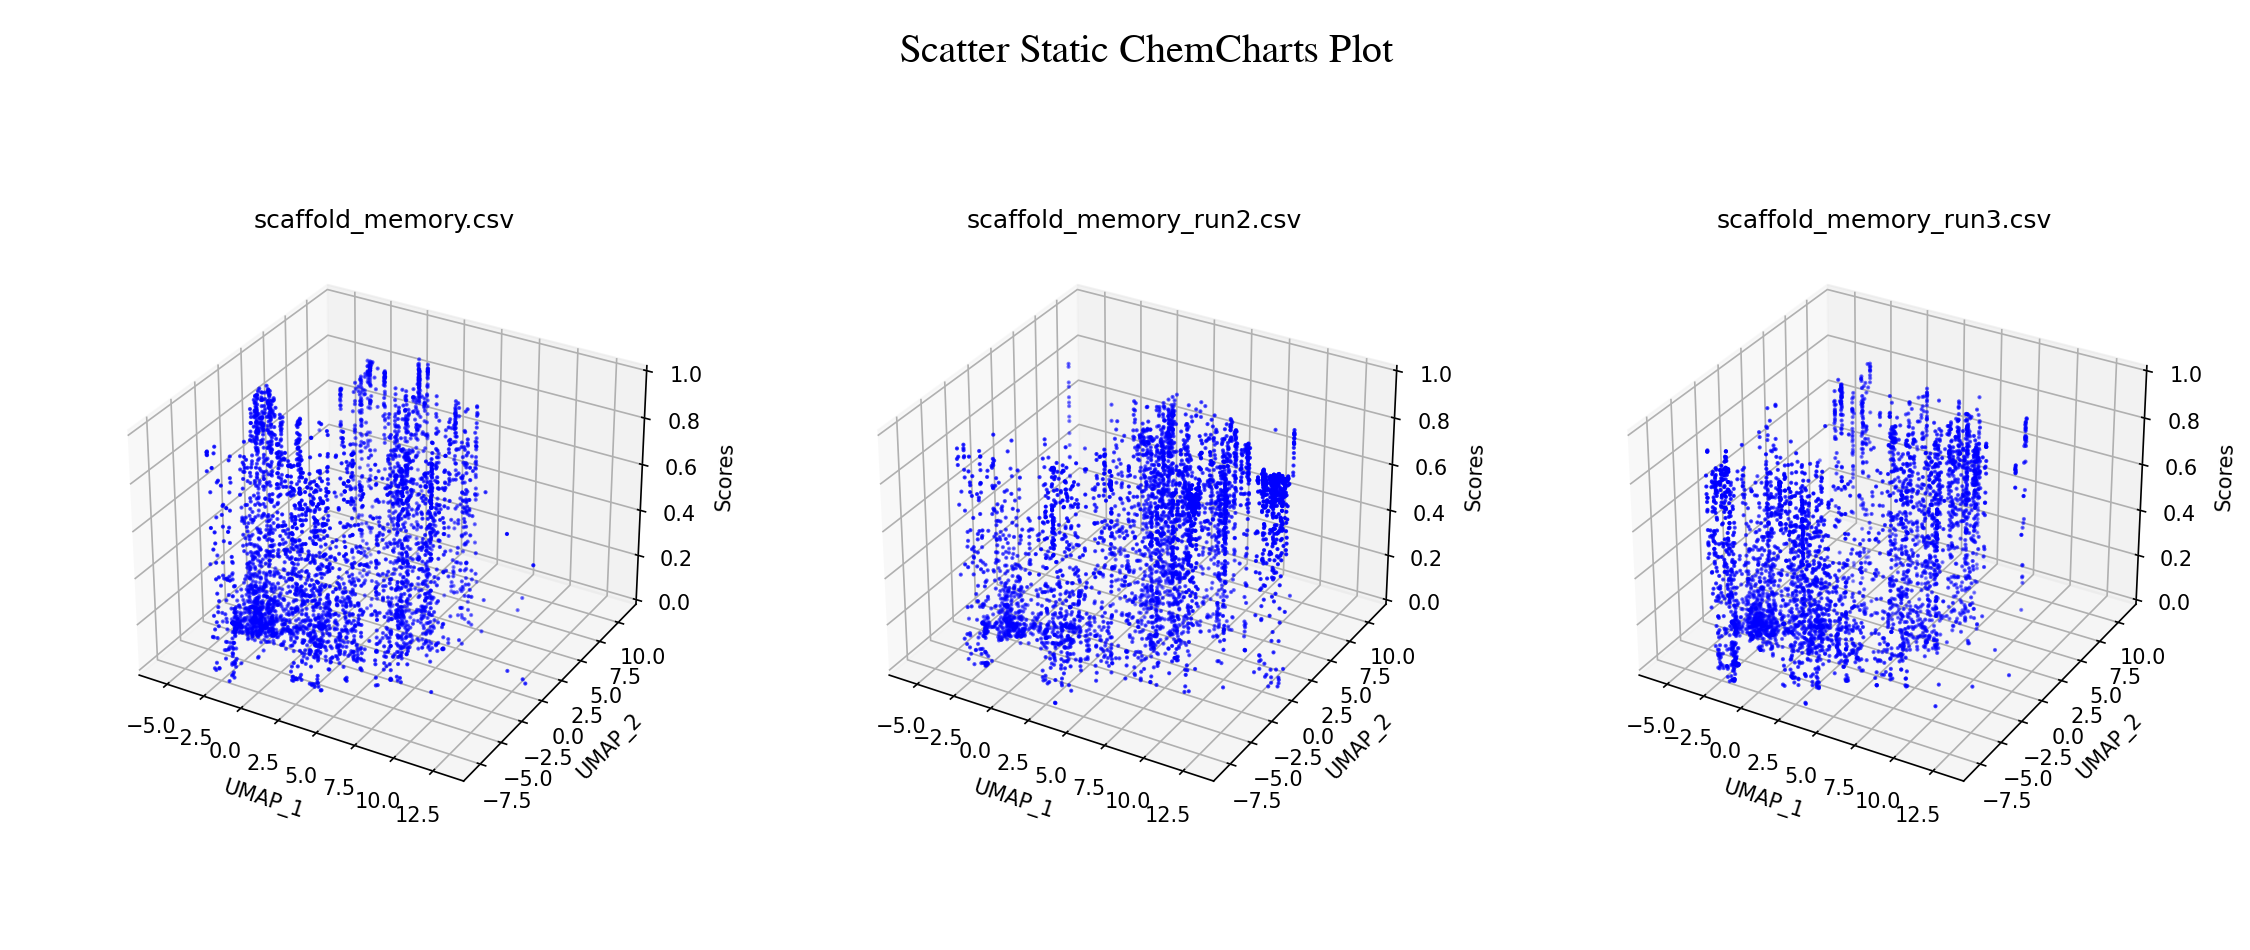

In [32]:

# generates a scatter static plot from "multiple_plot_test.pkl"
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "multiple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "scatter_static_plot",
       "parameters":  {"title": "Scatter Static ChemCharts Plot",                     # set plot title (default: Scatter Static 
                                                                                      # Chemcharts Plot)
                       "color": "#0000ff",                                            # set marker color with a hex color code 
                                                                                      # (default: #0000ff)
                       "s": 1,                                                        # set marker size (default: 6)
                       "xlim": [-6.5, 14],                                            # set xlim and ylim when plotting multiple 
                                                                                      # chemdata objects (datasets) to ensure
                                                                                      # all subplots show the same excerpt
                       "ylim": [-9, 12],
                       "valuelim": [0, 1],                                            # set valuelim when plotting multiple chemdata  
                                                                                      # objects (datasets) to ensure all subplots 
                                                                                      # show the same score axis
                       "value_column": "total_score",                                 # choose value for this plot
                       "value_name": "Scores"},                                       # choose value name (will also be the y-axis title)
        "settings": {"path": os.path.join(output_dir, "scatter_static_plot.png"),     # set output path including file name
                     "format": "png",                                                 # set file format (default: png) 
                     "dpi": 150,                                                      # set dpi (default: 150)
                     "figsize": [5, 5]}                                               # set figure size (default: [5, 5])
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_scatter_static_multiple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}

# display 
Image(filename=os.path.join(output_dir, "scatter_static_plot.png"), width=1000, height=800)      # with "width" and "height" 
                                                                                                 # the displayed image size can be 
                                                                                                 # adjusted     


Task data_loading completed.
Trisurf interactive function does not support multiple input objects. Proceeding with first object.
Task generate_plot completed.


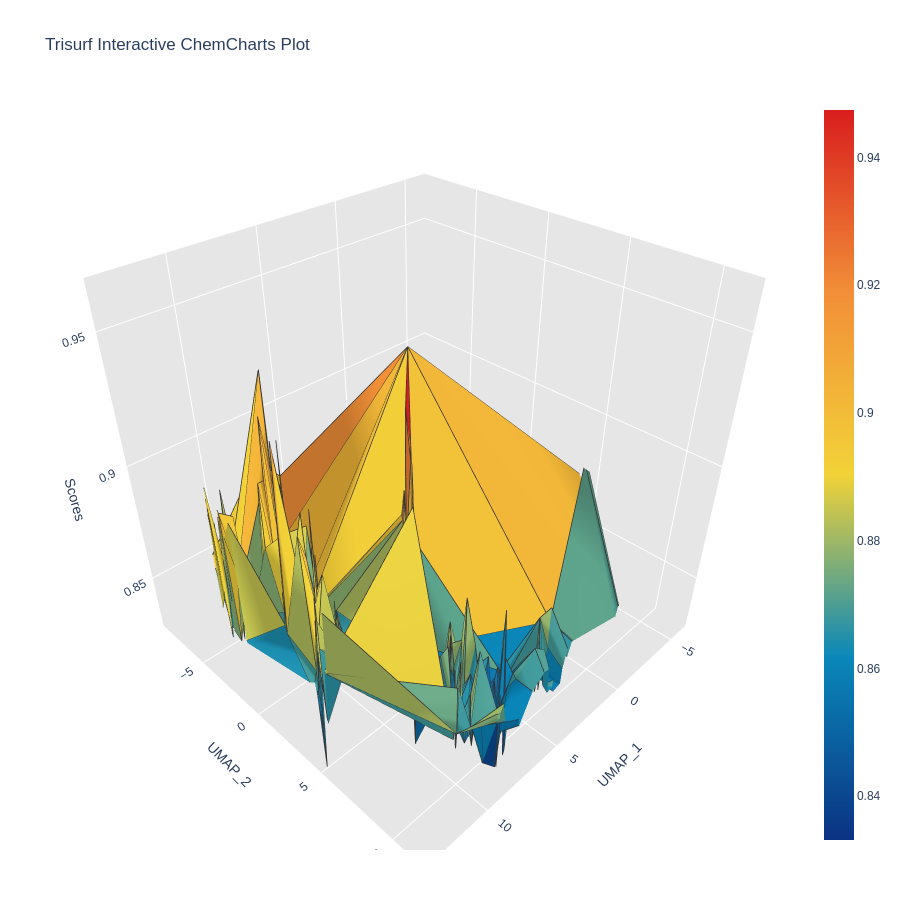

In [33]:

# generates an interactive trisurf plot from the "groups_plot_test.pkl"
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "groups_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "trisurf_interactive_plot",
       "parameters":  {"title": "Trisurf Interactive ChemCharts Plot",                 # set plot title (default: Trisurf 
                                                                                       # Interactive Chemcharts Plot)
                       "color": "Portland",                                            # set marker color with a plotly built-in 
                                                                                       # continuous color scale (default: Portland)
                       "xlim": [-6.5, 14],                                             # set xlim and ylim when plotting multiple 
                                                                                       # chemdata objects (datasets) to ensure all 
                                                                                       # subplots show the same excerpt
                       "ylim": [-9, 12],
                       "value_column": "total_score",                                  # choose value for this plot
                       "value_name": "Scores"},                                        # choose value name (will also be the y-axis title)
       "settings": {"path": os.path.join(output_dir, "trisurf_interactive_plot.png"),  # set output path including file name
                    "view": True,                                                      # set "True" if pop-up window is 
                                                                                       # desired (default: false)
                    "format": "png",                                                   # set file format (default: png) 
                    "figsize": [900, 900]}                                             # set figure size (default: [900, 900])
      }
       
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_trisurf_interactive_groups.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}

# display
Image(filename=os.path.join(output_dir, "trisurf_interactive_plot.png"), width=400, height=200)   # with "width" and "height" the 
                                                                                                  # displayed image size can be 
                                                                                                  # adjusted     


Task data_loading completed.
Task generate_plot completed.


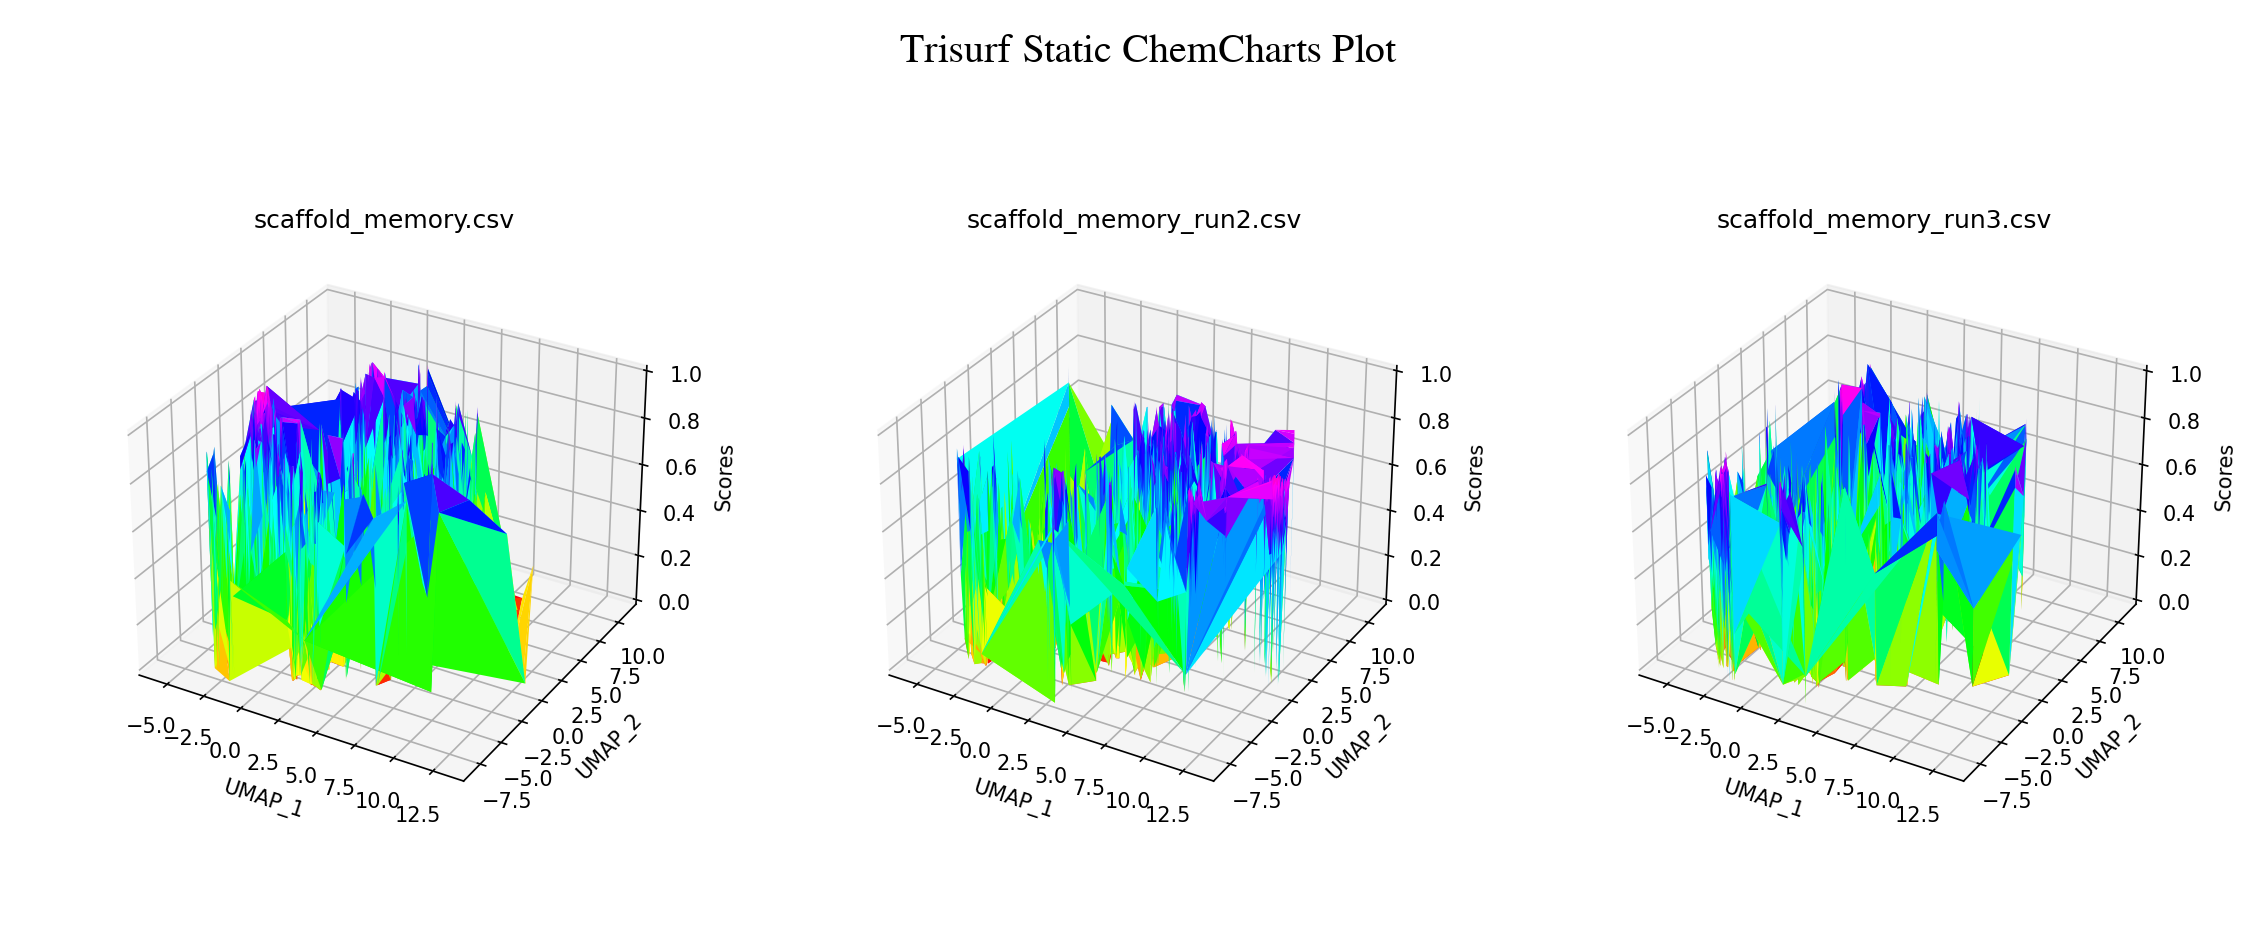

In [34]:

# generates a static trisurf plot from the "multiple_plot_test.pkl"
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "multiple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "trisurf_static_plot",
       "parameters":  {"title": "Trisurf Static ChemCharts Plot",                       # set plot title 
                                                                                        # (default: Trisurf Static Chemcharts Plot)
                       "color": "gist_rainbow",                                         # set marker color with a matplotlib colormap 
                                                                                        # (default: gist_rainbow)
                       "xlim": [-6.5, 14],                                              # set xlim and ylim when plotting multiple 
                                                                                        # chemdata objects (datasets) to ensure  
                                                                                        # all subplots show the same excerpt
                       "ylim": [-9, 12],
                       "valuelim": [0, 1],                                              # set valuelim when plotting multiple chemdata  
                                                                                        # objects(datasets) to ensure all subplots  
                                                                                        # show the same score axis
                       "value_column": "total_score",                                   # choose value for this plot
                       "value_name": "Scores"},                                         # choose value name (will also be the y-axis title)
        "settings": {"path": os.path.join(output_dir, "trisurf_static_plot.png"),       # set output path including file name
                     "format": "png",                                                   # set file format (default: png) 
                     "dpi": 150,                                                        # set dpi (default: 150)
                     "figsize": [5, 5]}                                                 # set figure size (default: [5, 5])
      }
    
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_trisurf_static_multiple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}

# display
Image(filename=os.path.join(output_dir, "trisurf_static_plot.png"), width=1000, height=800)     # with "width" and "height" the 
                                                                                                # displayed image size can be 
                                                                                                # adjusted     


In [35]:

# generates four contour plots (the first three in 2D and the last one in 3D) from the "simple_plot_test.pkl"

# Reminder: the 3D plot requires values in contrast to the 2D plot!

conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "contour_plot",
       "parameters":  {"title": "2D Contour ChemCharts Plot",                           # set plot title 
                                                                                        # (default: Contour Chemcharts Plot)
                       "xlim": [-6.5, 14],                                              # set xlim and ylim when plotting multiple 
                                                                                        # chemdata objects (datasets) to ensure  
                                                                                        # all subplots show the same excerpt
                       "ylim": [-9, 12]},                                               
        "settings": {"path": os.path.join(output_dir, "2D_Contour_ChemCharts_Plot.png"),# set output path including file name
                     "format": "png",                                                   # set file format (default: png) 
                     "dpi": 150,                                                        # set dpi (default: 150)
                     "figsize": [6, 6]}                                                 # set figure size (default: [5, 5])
      },
      {"task": "generate_plot",
       "type": "contour_plot",
       "parameters":  {"title": "2D (shade and bandwidth) Contour ChemCharts Plot",     
                       "color": "Blues",                                                # set marker color with a matplotlib colormap 
                                                                                        # (default: None)
                       "xlim": [-6.5, 14],                                               
                                                                                          
                                                                                        
                       "ylim": [-9, 12],
                       "bw_adjust": .5,                                                 # set bandwidth (default: 1)
                       "shade": True},                                                  # set on "True" if setting is desired 
                                                                                        # (default: None)   
        "settings": {"path": os.path.join(output_dir, "2D_shade_bandwidth_Contour_ChemCharts_Plot.png"),
                     "format": "png",                                                    
                     "dpi": 150,                                                        
                     "figsize": [6, 6]}                                                 
      },
      {"task": "generate_plot",
       "type": "contour_plot",
       "parameters":  {"title": "2D (thresh) Contour ChemCharts Plot",                            
                                                                                        
                       "color": "Blues",                                                 
                                                                                        
                       "xlim": [-6.5, 14],                                               
                                                                                         
                                                                                        
                       "ylim": [-9, 12],
                       "shade": True,                                                     
                       "thresh": 0.1},                                                  # set thresh (default: 0.05)
        "settings": {"path": os.path.join(output_dir, "2D_thresh_Contour_ChemCharts_Plot.png"),
                     "format": "png",                                                    
                     "dpi": 150,                                                        
                     "figsize": [6, 6]}                                                 
      },
      {"task": "generate_plot",
       "type": "contour_plot",
       "parameters":  {"title": "3D Contour ChemCharts Plot",                           # set plot title 
                                                                                        # (default: Contour Chemcharts Plot)
                       "color": "magma",                                                # set marker color with a matplotlib colormap 
                                                                                        # (default: magma)
                       "xlim": [-6.5, 14],                                              # set xlim and ylim when plotting multiple 
                                                                                        # chemdata objects (datasets) to ensure  
                                                                                        # all subplots show the same excerpt
                       "ylim": [-9, 12],
                       "valuelim": [0, 1],                                              # set valuelim when plotting multiple chemdata  
                                                                                        # objects(datasets) to ensure all subplots  
                                                                                        # show the same score axis
                       "value_column": "total_score",                                   # choose value for this plot
                       "value_name": "Scores",                                          # choose value name (will also be the y-axis title)
                       "mesh_closeness": 2},                                            # set mesh closeness (default: 2)
        "settings": {"path": os.path.join(output_dir, "3D_Contour_ChemCharts_Plot.png"),# set output path including file name
                     "format": "png",                                                   # set file format (default: png) 
                     "dpi": 150,                                                        # set dpi (default: 150)
                     "figsize": [6, 6]}                                                 # set figure size (default: [5, 5])
      }
    
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_contour_simple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}


Task data_loading completed.
Task generate_plot completed.
Task generate_plot completed.
Task generate_plot completed.
Task generate_plot completed.


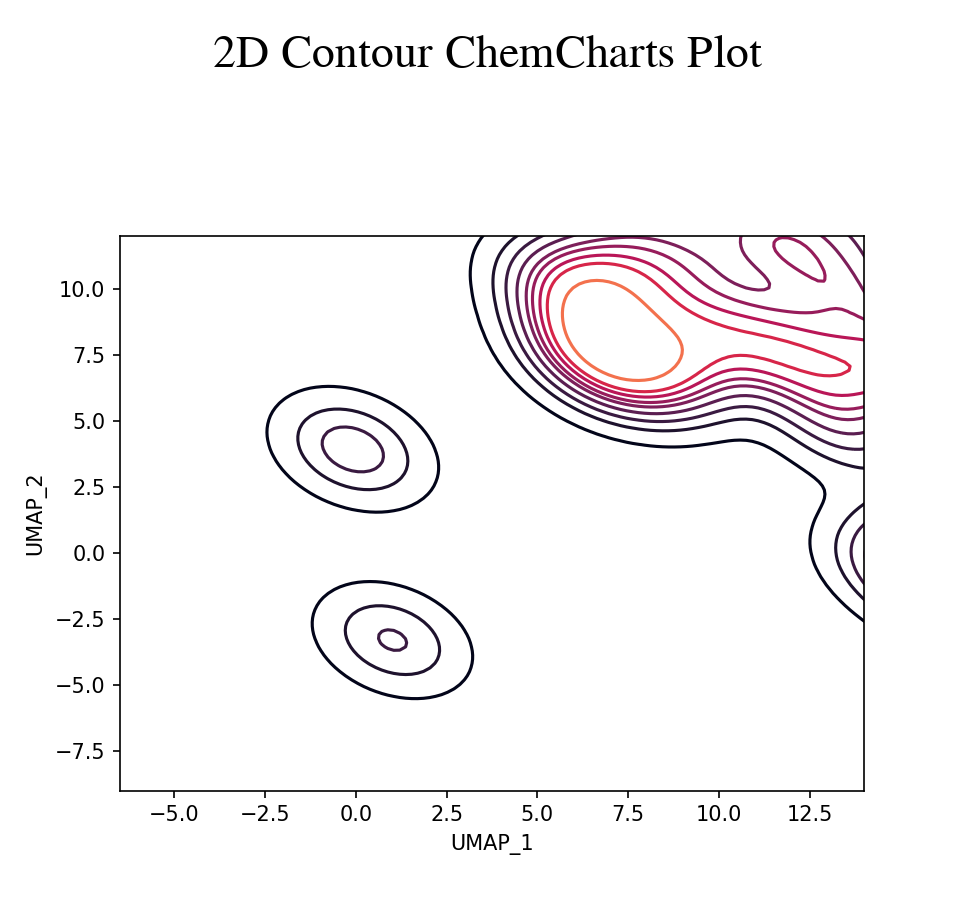

In [36]:

# display 2D contour plot
Image(filename=os.path.join(output_dir, "2D_Contour_ChemCharts_Plot.png"), width=400, height=200) # with "width" and "height" the 
                                                                                                  # displayed image size can be 
                                                                                                  # adjusted     


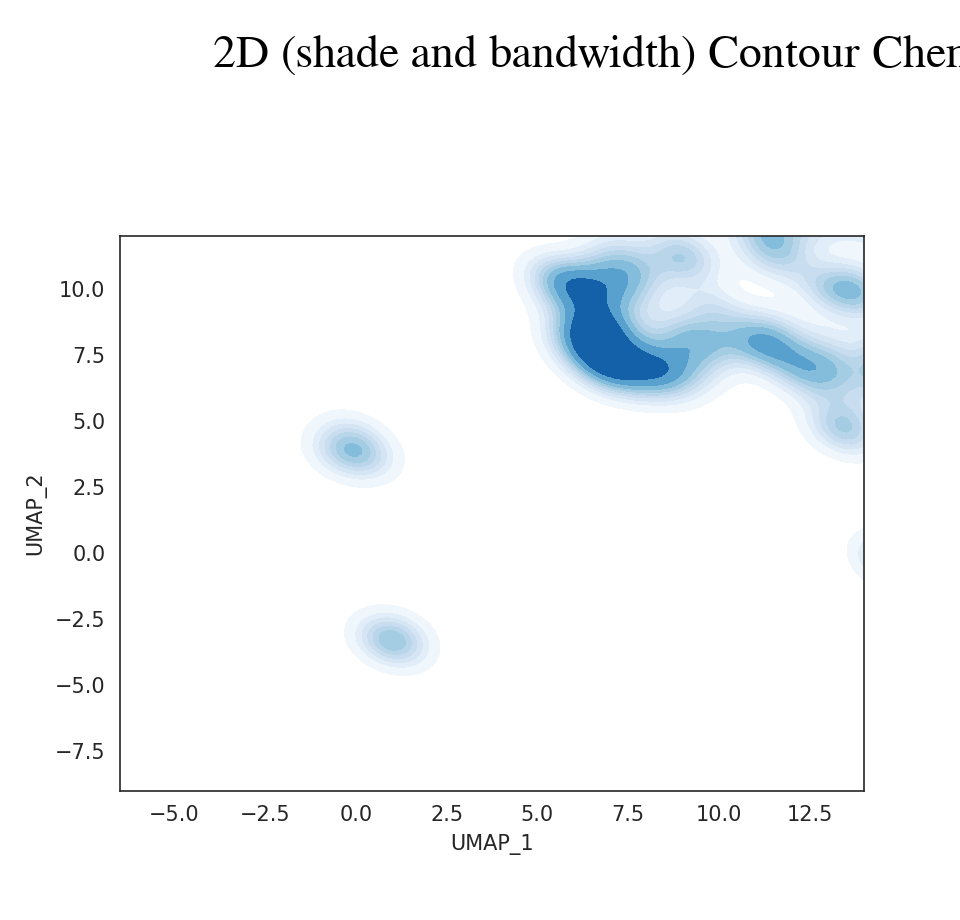

In [37]:

# display 2D (shade and bandwidth) contour plot
Image(filename=os.path.join(output_dir, "2D_shade_bandwidth_Contour_ChemCharts_Plot.png"), width=400, height=200) 
                                                                                                  # with "width" and "height" the 
                                                                                                  # displayed image size can be 
                                                                                                  # adjusted     


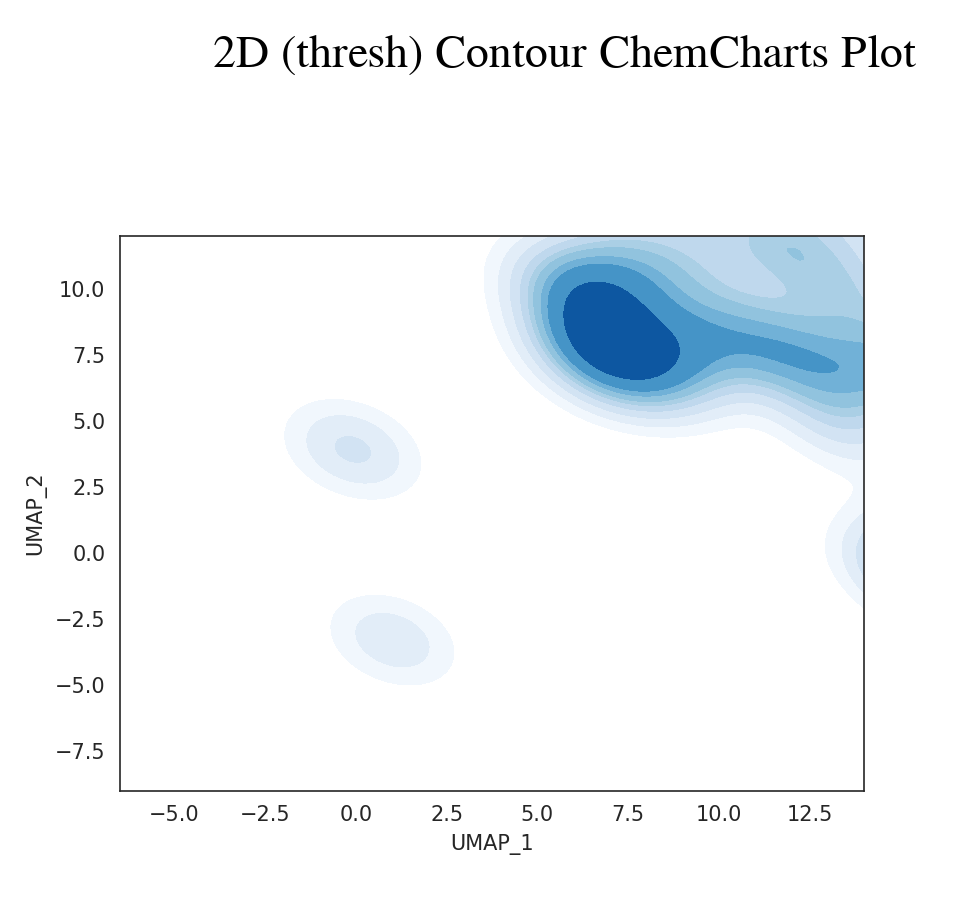

In [38]:

# display 2D (thresh) contour plot
Image(filename=os.path.join(output_dir, "2D_thresh_Contour_ChemCharts_Plot.png"), width=400, height=200) 
                                                                                                  # with "width" and "height" the 
                                                                                                  # displayed image size can be 
                                                                                                  # adjusted     


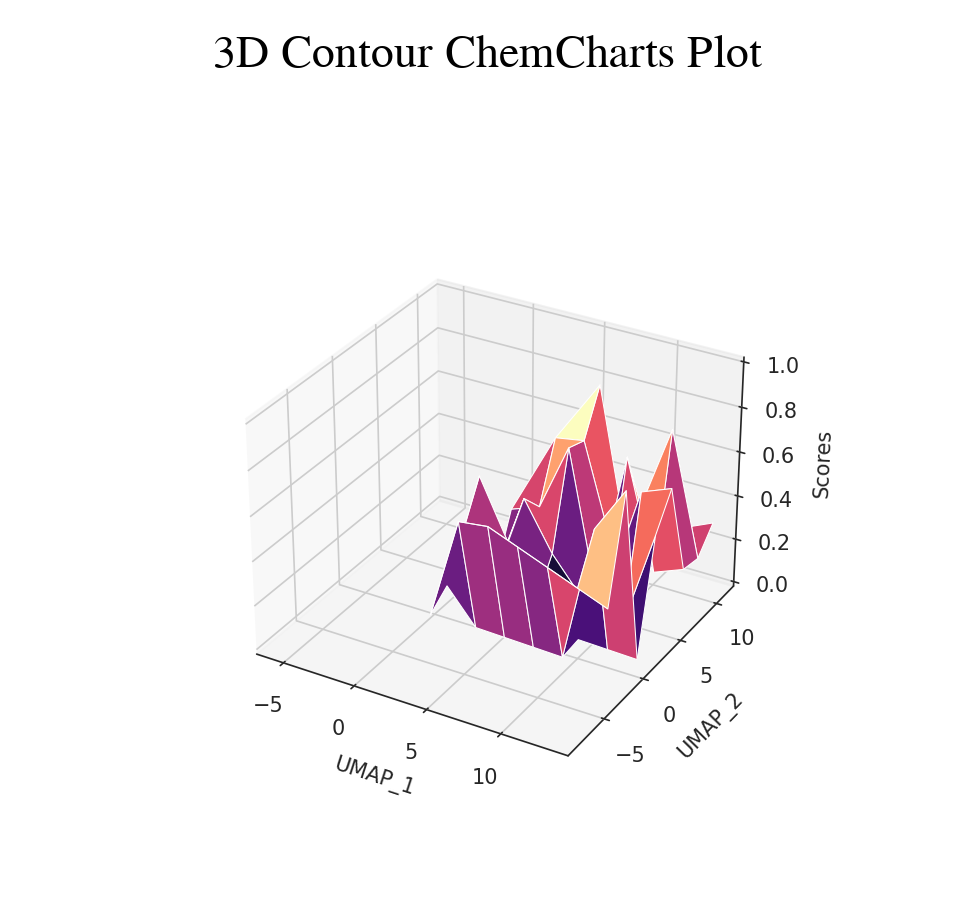

In [39]:

# display 3D contour plot
Image(filename=os.path.join(output_dir, "3D_Contour_ChemCharts_Plot.png"), width=400, height=200) # with "width" and "height" the 
                                                                                                  # displayed image size can be 
                                                                                                  # adjusted     


In [ ]:

# generates a scatter interactive mol plot
conf={
  "chemcharts": {
    "header": {},
    "execution": [
      {"task":  "data_loading",
       "input":  [os.path.join(output_dir, "simple_plot_test.pkl")],
       "input_type":  "pkl"
      },
      {"task": "generate_plot",
       "type": "scatter_interactive_mol_plot",
       "parameters":  {"title": "Scatter Interactive Mol ChemCharts Plot",                # set plot title (default: Scatter Interactive 
                                                                                          # Chemcharts Plot)
                       "marker_size": 1,                                                  # set marker size (default: 1)
                       "xlim": [-6.5, 14],                                                # set xlim and ylim when plotting multiple 
                                                                                          # chemdata objects (datasets) to ensure all 
                                                                                          # subplots show the same excerpt
                       "ylim": [-9, 12],                                              
                       "value_column": "total_score",                                     # choose value for this plot
                       "value_name": "Scores"},                                           # choose value name (will also be the y-axis 
                                                                                          # as well as colorbar title)
       "settings": {"path": os.path.join(output_dir, "scatter_interactive_mol_plot.png"), # set output path including file name
                    "view": True,                                                         # set on "True" if pop-up window is 
                                                                                          # desired (default: false)
                    "format": "png",                                                      # set file format (default: png) 
                    "figsize": [500, 500]}                                                # set figure size (default: [900, 900])
      }
    ]
  }
}

# write-out of configuration file
configuration_JSON_path = os.path.join(output_dir, "chemcharts_config_plots_scatter_int_mol_simple.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(conf, f, indent=4, sort_keys=True)
    
# execution
!{chemcharts_env}/bin/python {chemcharts_dir}/src/chemcharts/scripts/chemcharts_json.py -conf {configuration_JSON_path}

# Note: open the link following "Dash is running on ..."
   